In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib 
import math
from functools import reduce
from math import gamma
from operator import mul
from scipy.special import loggamma
from scipy.stats import dirichlet, multivariate_normal

import torch
import tikzplotlib

# Define calculations and plottings tools

561


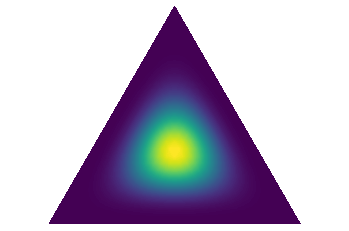

In [2]:
from scipy.special import gammaln, xlogy

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])

refiner = tri.UniformTriRefiner(triangle)
trimesh = refiner.refine_triangulation(subdiv=4)


midpoints = [(corners[(i + 1) % 3] + corners[(i + 2) % 3]) / 2.0 \
             for i in range(3)]
def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.'''
    s = [(corners[i] - midpoints[i]).dot(xy - midpoints[i]) / 0.75 \
         for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)


def softmax_transform(a):
    x = np.exp(a)/np.sum(np.exp(a))
    return(x)

def beta_function(alpha):
    return(np.exp(np.sum([loggamma(a_i) for a_i in alpha]) - loggamma(np.sum(alpha))))    

class Dirichlet(object):
    def __init__(self, alpha):
        self._alpha = np.array(alpha)
        self._coef = np.sum(gammaln(alpha)) - gammaln(np.sum(alpha))    
        
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        return(np.exp(- self._coef+ np.sum((xlogy(self._alpha-1, x.T)).T, 0)))
    
class Normal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1 / (np.sqrt((2*np.pi)**3 * np.linalg.det(Sigma)))
        
    def pdf(self, x):
        """Calculate 3D Gaussian"""
        y = self.const * np.exp(-0.5 * (x - self.mu).T @ self.Sigma @ (x - self.mu))
        return(y)
    
class logitNormal3D(object):
    
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.const = 1/ (np.sqrt(np.linalg.det(2 * np.pi * self.Sigma)))
        
    def pdf(self, x):
        part_one = self.const / np.prod(x)
        logistic = logistic_transform(x)
        part_two = np.exp(-0.5*(logistic - self.mu).T @ self.Sigma @ (logistic - self.mu))
        y = part_one * part_two
        return(y)

def draw_pdf_contours(dist, nlevels=200, subdiv=5, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]
    xys = [xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)]
    #print(len(pvals))
    #print(xys)
    print(len(xys))

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    
draw_pdf_contours(Dirichlet([5, 5, 5]))

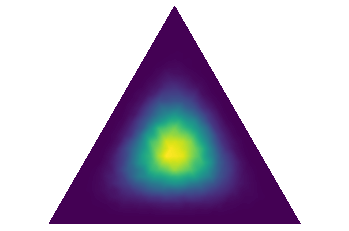

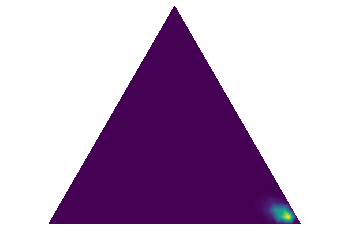

In [3]:
def argmin_norm(sample, positions):
    return(np.argmin(np.sum(np.square(sample - positions), axis=1)))

def sample_dirichlet_contours(alpha, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)
    counts = np.zeros(len(xys))
    for x in dirichlet_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
def sample_Normal_contours(mu, sigma, nlevels=200, subdiv=5, num_samples=100000, **kwargs):

    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    counts = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts[argmin_norm(x, xys)] += 1
    
    pvals = counts/num_samples

    plt.tricontourf(trimesh, pvals, nlevels, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.show()
    
sample_dirichlet_contours(np.array([5, 5, 5]))
sample_Normal_contours(np.array([-1, 2, -1]), 0.1*np.eye(3))

In [4]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

In [5]:
new_cool = cm.get_cmap('cool', 256)
new_cool = new_cool(np.linspace(0.3,1 ,256))
new_cool = ListedColormap(new_cool, name='new_cool')

In [6]:
new_coolwarm = cm.get_cmap('coolwarm', 256)
new_coolwarm = new_coolwarm(np.linspace(0.35,0.95,256))
new_coolwarm = ListedColormap(new_coolwarm, name='new_coolwarm')

In [7]:
new_bupu = cm.get_cmap('BuPu', 256)
new_bupu = new_bupu(np.linspace(0.4,1 ,256))
new_bupu = ListedColormap(new_bupu, name='new_bupu')

In [176]:
#test the transformations from Gaussian to Dirichlet and back

def get_mu_from_Dirichlet(alpha):
    K = len(alpha)
    mu = []
    for i in range(K):
        mu_i = np.log(alpha[i]) - 1/K * np.sum(np.log(alpha))
        mu.append(mu_i)
        
    return(np.array(mu))

def sigma_regularizer(Sigma):
    
    Sigma_new = np.zeros(np.shape(Sigma))
    n = len(Sigma[0])
    for i in range(n):
        for j in range(n):
            Sigma_new[i][j] = Sigma[i][j]  - Sigma[i] @ Sigma[:,j] * 1/Sigma.sum()
        
    return(Sigma_new)

def get_Sigma_from_Dirichlet(alpha):
    K = len(alpha)
    sum_of_inv = 1/K * np.sum(1/np.array(alpha))
    Sigma = np.zeros((K,K))
    for k in range(K):
        for l in range(K):
            delta = 1 if k==l else 0
            Sigma[k][l] = delta * 1/alpha[k] - 1/K*(1/alpha[k] + 1/alpha[l] - sum_of_inv)
            
    return(Sigma)

def correct_mu(mu, Sigma):
    return(mu - Sigma.sum(0) * mu.sum() / Sigma.sum())

def correct_Sigma(mu, Sigma):
    return(Sigma - np.outer(Sigma.sum(0), Sigma.sum(1)) / Sigma.sum())



def get_alpha_from_Normal(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    for k in range(K):
        alpha.append(1/Sigma[k][k]*(1 - 2/K + np.exp(mu[k])/K**2 * sum_exp))
        
    return(np.array(alpha))

def get_alpha_from_Normal2(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = np.sum(np.exp(-1*np.array(mu)))
    for k in range(K):
        alpha.append(1/Sigma[k][k]*(1 - 2/K + np.max([np.log(np.exp(mu[k])/K**2), 0.01]) * sum_exp))
        
    return(np.array(alpha))

def get_alpha_from_Normal_full(mu, Sigma):
    K = len(Sigma[0])
    alpha = np.zeros(K)
    sum_exp = np.sum(np.exp(-np.array(mu)))
    for k in range(K):
        for l in range(K):
            core = (1/K + np.exp(mu[k] - mu[l])/K) + np.exp(mu[k])/K**2 * sum_exp
            if l == k:
                alpha[k] += 1/Sigma[k][l] * (1 - 1/K - np.exp(mu[k] - mu[l])/K + np.exp(mu[k])/K**2 * sum_exp)
            elif Sigma[k][l] != 0:
                alpha[k] += 1/Sigma[k][l] * (-1/K - np.exp(mu[k] - mu[l])/K + np.exp(mu[k])/K**2 * sum_exp)
                
    #correct for K
    alpha/= K
        
    return(alpha)

def get_alpha_from_Normal_dissect(mu, Sigma):
    alpha = []
    K = len(Sigma[0])
    sum_exp = np.sum(np.exp(-np.array(mu)))
    print("sum_exp: ", sum_exp)
    for k in range(K):
        print("Sigma[k][k]: ", Sigma[k][k])
        print("np.exp(mu[k])/K**2 * sum_exp: ", np.exp(mu[k])/K**2 * sum_exp)
        alpha.append(1/Sigma[k][k]*(1 - 2/K + np.exp(mu[k])/K**2 * sum_exp))
        
    return(np.array(alpha))

def get_alpha_from_Normal_batch(mu, Sigma):
    mu, Sigma = torch.from_numpy(mu), torch.from_numpy(Sigma)
    batch_size, K = mu.size(0), mu.size(-1)
    Sigma_d = torch.diagonal(Sigma, dim1=1, dim2=2)
    sum_exp = torch.sum(torch.exp(-1*torch.Tensor(mu)), dim=1).view(-1,1)
    alpha = 1/Sigma_d * (1 - 2/K + torch.exp(mu)/K**2 * sum_exp)
    
    assert(alpha.size() == mu.size())
    
    return(alpha)

def alphas_norm(alphas):
    alphas = np.array(alphas)
    return(alphas/alphas.sum(axis=1).reshape(-1,1))

def alphas_variance(alphas):
    alphas = np.array(alphas)
    norm = alphas_norm(alphas)
    nom = norm * (1 - norm)
    den = alphas.sum(axis=1).reshape(-1,1) + 1
    return(nom/den)

def get_norm_variance_alphas(alphas):
    eps=10e-20
    a = np.array(alphas)
    a /= (np.sqrt(alphas_variance(a)) + eps)
    #a /= a.sum(1).reshape(-1,1)
    return(a)

def get_alphas_mS_batch(mu, Sigma):
    
    n = mu.size(0)
    alphas = torch.zeros(n, mu.size(1))
    for i in range(n):
        alphas[i] = get_alphas_from_mS(mu[i], Sigma[i])
        
    return(alphas)

from scipy.special import digamma, polygamma

alpha_test = np.array([1.3, 1.3, 1.6])
print("alpha start: ", alpha_test)
mu_test = get_mu_from_Dirichlet(alpha_test)
print("mu: ", mu_test)
Sigma_test = get_Sigma_from_Dirichlet(alpha_test)
print("Sigma: ", Sigma_test)
alpha_end = get_alpha_from_Normal(mu_test, Sigma_test)
print("alpha end: ", alpha_end)
alpha_end_full = get_alpha_from_Normal_full(mu_test, Sigma_test)
print("alpha end full: ", alpha_end_full)

alpha start:  [1.3 1.3 1.6]
mu:  [-0.06921312 -0.06921312  0.13842624]
Sigma:  [[ 0.49679487 -0.2724359  -0.22435897]
 [-0.2724359   0.49679487 -0.22435897]
 [-0.22435897 -0.22435897  0.44871795]]
alpha end:  [1.3 1.3 1.6]
alpha end full:  [1.3 1.3 1.6]


In [43]:
# check Agustinus condition from paper
def condition(alpha):
    alpha_sum = alpha.sum()
    alpha_sum_not_l = alpha_sum - alpha
    rhs = 1/4 * (np.sqrt(9* alpha_sum_not_l**2 + 10 * alpha_sum_not_l + 1) - alpha_sum_not_l + 1)
    return(alpha > rhs)

In [128]:
def correct_alpha(alpha, kappa):
    K = len(alpha)
    log_a_c = np.log(alpha) - kappa * (np.log(alpha) - 1/K * np.log(alpha).sum())
    return(np.exp(log_a_c))

In [44]:
mu_test1 = np.array([-1,-2,1])
#Sigma_test1 = np.eye(3)
Sigma_test1 = np.array([[1,     -0.3, -0.5],
                        [-0.3,     2, -0.3],
                        [-0.5, -0.3, 0.5]])
mu_test1 = correct_mu(mu_test1, Sigma_test1)
Sigma_test1 = correct_Sigma(mu_test1, Sigma_test1)
print("mu_test1: ", mu_test1)
print("Sigma_test1: ", Sigma_test1)
alpha_test1 = get_alpha_from_Normal(mu_test1, Sigma_test1)
alpha_test1_full = get_alpha_from_Normal_full(mu_test1, Sigma_test1)

print(alpha_test1)
print(alpha_test1_full)
print(condition(alpha_test1))

mu_test1:  [-0.69230769  0.15384615  0.53846154]
Sigma_test1:  [[ 0.96923077 -0.51538462 -0.45384615]
 [-0.51538462  0.49230769  0.02307692]
 [-0.45384615  0.02307692  0.43076923]]
[0.541223   1.58242904 2.29380653]
[ 0.54068108 -0.69704407 -1.06350155]
[False False  True]


In [29]:
alpha_test2 = np.array([2e-2,3e-2,1e-3])
mu_test2 = get_mu_from_Dirichlet(alpha_test2)
Sigma_test2 = get_Sigma_from_Dirichlet(alpha_test2)
print(Sigma_test2)

[[ 137.03703704   92.59259259 -229.62962963]
 [  92.59259259  131.48148148 -224.07407407]
 [-229.62962963 -224.07407407  453.7037037 ]]


In [30]:
correct_Sigma(mu_test2, Sigma_test2)

array([[ 137.03703704,   92.59259259, -229.62962963],
       [  92.59259259,  131.48148148, -224.07407407],
       [-229.62962963, -224.07407407,  453.7037037 ]])

In [31]:
def correct_mu_batch(mu, Sigma):
    return(mu - (Sigma.sum(-1) * mu.sum(-1).reshape(-1,1)) / Sigma.sum(axis=(1,2)).reshape(-1,1))

def correct_Sigma_batch(mu, Sigma):
    return(Sigma - np.einsum('bi,bj->bij', Sigma.sum(-1), Sigma.sum(-2)) / Sigma.sum(axis=(1,2)).reshape(-1,1,1))

In [179]:
mu_test1_batch = np.stack([np.array([0,0,0]), np.array([1,1,1]), np.array([10,2,3]), np.array([1,1,-2])])
Sigma_test1_batch = np.stack([np.eye(3), 2*np.eye(3), 3*np.eye(3), 4*np.eye(3)])
print(np.shape(mu_test1_batch))
print(np.shape(Sigma_test1_batch))

mu_test1_batch_corrected = correct_mu_batch(mu_test1_batch, Sigma_test1_batch)
Sigma_test1_batch_corrected = correct_Sigma_batch(mu_test1_batch, Sigma_test1_batch)

print(mu_test1_batch_corrected)
print(Sigma_test1_batch_corrected)

print(correct_mu(mu_test1_batch[0], Sigma_test1_batch[0]))
print(correct_Sigma(mu_test1_batch[0], Sigma_test1_batch[0]))

(4, 3)
(4, 3, 3)
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 5. -3. -2.]
 [ 1.  1. -2.]]
[[[ 0.66666667 -0.33333333 -0.33333333]
  [-0.33333333  0.66666667 -0.33333333]
  [-0.33333333 -0.33333333  0.66666667]]

 [[ 1.33333333 -0.66666667 -0.66666667]
  [-0.66666667  1.33333333 -0.66666667]
  [-0.66666667 -0.66666667  1.33333333]]

 [[ 2.         -1.         -1.        ]
  [-1.          2.         -1.        ]
  [-1.         -1.          2.        ]]

 [[ 2.66666667 -1.33333333 -1.33333333]
  [-1.33333333  2.66666667 -1.33333333]
  [-1.33333333 -1.33333333  2.66666667]]]
[0. 0. 0.]
[[ 0.66666667 -0.33333333 -0.33333333]
 [-0.33333333  0.66666667 -0.33333333]
 [-0.33333333 -0.33333333  0.66666667]]


In [191]:
# OOD sample; we expect alpha_0 == alpha_1 - at least approximately

mu_real1 = np.array([ 6.4000, -8.4087])
Sigma_real1 = np.array([[13975.7568, 0.0000],
                        [0.0000, 13975.7529]])

mu_real1_c = np.array([7.4044, -7.4044])
Sigma_real1_c = np.array([[ 6987.8774, -6987.8774],
                          [-6987.8774,  6987.8774]])

mu_real1_c /= np.sqrt(np.diag(Sigma_real1_c))
Sigma_real1_c /= Sigma_real1_c

alpha_real1 = get_alpha_from_Normal(mu_real1, Sigma_real1)
alpha_real1_full = get_alpha_from_Normal_full(mu_real1, Sigma_real1)
print(alpha_real1)
print(alpha_real1_full)

alpha_real1_c = get_alpha_from_Normal(mu_real1_c, Sigma_real1_c)
alpha_real1_c_alt = get_alpha_from_Normal2(mu_real1_c, Sigma_real1_c)
alpha_real1_c_full = get_alpha_from_Normal_full(mu_real1_c, Sigma_real1_c)
print("alpha: ", alpha_real1_c)
print("alpha alt: ", alpha_real1_c_alt)
#print(alpha_real1_c_full)

#_ = get_alpha_from_Normal_dissect(mu_real1_c, Sigma_real1_c)
alpha_real1_cc = correct_alpha(alpha_real1_c, kappa=0.9)
print("after alpha correction: ", alpha_real1_cc)

[4.82949287e+01 1.78881306e-05]
[2.41474643e+01 8.94406528e-06]
alpha:  [0.54845328 0.45941301]
alpha alt:  [0.02007851 0.02007851]
after alpha correction:  [0.50642867 0.49753616]


In [124]:
from scipy.stats import norm
from scipy.special import gamma as gamma_func
from scipy.special import beta as beta_func

"""Transforms"""
def logit_transform(theta):
    return(np.log(theta/(1-theta)))

def logit_derivative(x):
    return(1/x + 1/(1-x))

def logistic_transform(a):
    return(1 / (1 + np.exp(-a)))

def logistic_derivative(x):
    return(logistic_transform(x) * (1- logistic_transform(x)))


def beta_pdf(x, a, b):
    nom = x ** (a-1) * (1 - x) ** (b-1)
    denom = beta_func(a, b)
    return(nom/denom)

def beta_t_logit_pdf(x, a, b):
    x_t = logistic_transform(x)
    nom = (x_t) ** (a) * (1- x_t) ** (b)
    denom = beta_func(a, b)
    return((nom/denom))

def beta_mu(a, b):
    return((a-1)/(a+b-2))

def beta_var(a, b):
    return(((a-1)*(b-1))/(a+b-2)**3)

"""transform: logit"""

def beta_t_logit_mu(a,b):
    return(np.log(a/b))

def beta_t_logit_var(a,b):
    return((a+b)/(a*b))

def logit_normal_back(x, mu, sigma):
    x_ = logit_transform(x)
    return(norm.pdf(x_, mu, sigma) * logit_derivative(x))

def plot_beta_t_logit(alpha2D, x_len):

    x = np.linspace(0,1, 1000 +1)
    x_t = np.linspace(-x_len/2,x_len/2, 1000 +1)
    
    a = alpha2D[0]
    b = alpha2D[1]
    mu = beta_t_logit_mu(a,b)
    sigma = np.sqrt(beta_t_logit_var(a, b))
    
    #plot 1: transform to other base
    y_t_logit = beta_t_logit_pdf(x_t, a, b)
    LP_approx_t_logit = norm.pdf(x_t, mu, sigma)

    #plot 2: transform back and reconstruct
    y_back = logit_normal_back(x, mu, sigma)
    y = beta_pdf(x, a, b)

    """Plots"""    
    plt.rc('text', usetex=True)
    plt.rc('xtick', labelsize=12)
    plt.rc('ytick', labelsize=15)
    plt.rc('axes', labelsize=15)
    
    legend_size=14
    xlabel_size=15
    ylabel_size=15
    title_size=15
    lw_size=2
    
    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(10, 3))

    #plot beta distribution in the transformed basis
    axs[0].plot(x_t, y_t_logit, 'r-', lw=lw_size)
    axs[0].plot(x_t, LP_approx_t_logit, 'r--', lw=lw_size)
    axs[0].set_xlabel('x', fontsize=xlabel_size)
    #axs[0].set_ylabel('$p(x)dx$', fontsize=ylabel_size)
    #axs[0].set_yticklabels([])
    #axs[0].set_yticks([])
    axs[0].set_title('Laplace in logit basis', fontsize=title_size)
    #axs[0].legend(prop={'size': legend_size});

    #plot backwards transformation of the LPA from the transformed to the standard basis
    axs[1].plot(x, y, 'k-', lw=lw_size)
    axs[1].plot(x, y_back, 'k--', lw=lw_size)
    #axs[1].set_yticklabels([])
    #axs[1].set_yticks([])
    axs[1].set_xlabel('$\pi$', fontsize=xlabel_size)
    #axs[1].set_ylabel('$p(\pi)d\pi$', fontsize=ylabel_size)
    axs[1].set_title('Back to standard basis', fontsize=title_size)
    #axs[1].legend(prop={'size': legend_size});

    plt.tight_layout()
        
    plt.show();

<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
<ipython-input-124-ef739ff61aeb>:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
<ipython-input-124-ef739ff61aeb>:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)


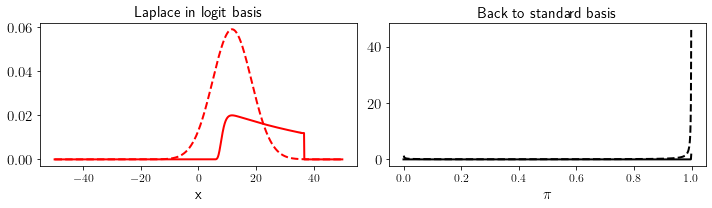

In [159]:
#plot_beta_t_logit(np.array([115, 0.07]), 100)
plot_beta_t_logit(np.array([2.6e3, 2.2e-2]), 100)

<ipython-input-98-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
<ipython-input-98-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
<ipython-input-98-ef739ff61aeb>:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
<ipython-input-98-ef739ff61aeb>:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
<ipython-input-98-ef739ff61aeb>:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)


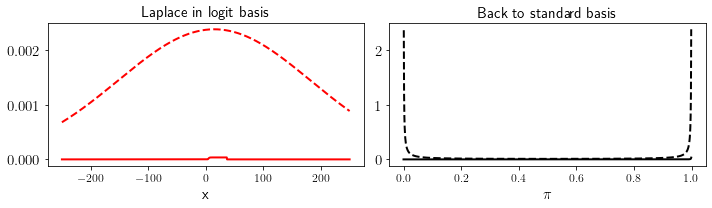

In [100]:
plot_beta_t_logit(alpha_real1_c, 500)

<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
<ipython-input-124-ef739ff61aeb>:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
<ipython-input-124-ef739ff61aeb>:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)


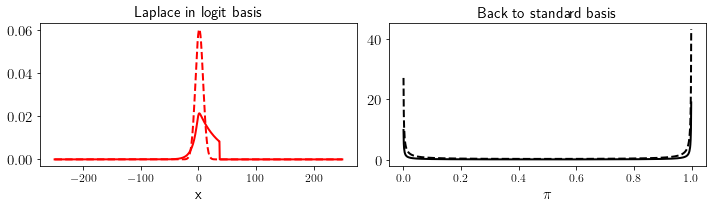

In [134]:
plot_beta_t_logit(alpha_real1_cc, 500)

In [190]:
# in dist sample; we expect alpha_0 << alpha_1 or alpha_1 << alpha_0

mu_real2 = np.array([2.6606,  -2.7122])
Sigma_real2 = np.array([[  41.8984,    0.0000],
                        [   0.0000,   41.8984]])

mu_real2_c = correct_mu(mu_real2, Sigma_real2)
Sigma_real2_c = correct_Sigma(mu_real2, Sigma_real2)
mu_real2_c /= np.sqrt(np.diag(Sigma_real2_c))
Sigma_real2_c /= Sigma_real2_c

print(mu_real2_c)
print(Sigma_real2_c)

alpha_real2 = get_alpha_from_Normal(mu_real2, Sigma_real2)
alpha_real2_full = get_alpha_from_Normal_full(mu_real2, Sigma_real2)
print(alpha_real2)
print(alpha_real2_full)

alpha_real2_c = get_alpha_from_Normal(mu_real2_c, Sigma_real2_c)
alpha_real2_c_alt = get_alpha_from_Normal2(mu_real2_c, Sigma_real2_c)
alpha_real2_c_full = get_alpha_from_Normal_full(mu_real2_c, Sigma_real2_c)
print("alpha: ", alpha_real2_c)
print("alpha alt: ", alpha_real2_c_alt)
#print(alpha_real2_c_full)

print("mean2: ", alpha_real2 / alpha_real2.sum())
print("mean2_c: ", alpha_real2_c / alpha_real2_c.sum())

alpha_real2_cc = correct_alpha(alpha_real2_c, kappa=0.9)
print("after alpha2 correction: ", alpha_real2_cc)

[ 0.58693088 -0.58693088]
[[1. 1.]
 [1. 1.]]
[1.29160855 0.00599451]
[0.64580428 0.00299725]
alpha:  [1.05861481 0.32729267]
alpha alt:  [0.02354491 0.02354491]
mean2:  [0.99538032 0.00461968]
mean2_c:  [0.76384234 0.23615766]
after alpha2 correction:  [0.62420495 0.55506909]


<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
<ipython-input-124-ef739ff61aeb>:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
<ipython-input-124-ef739ff61aeb>:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)


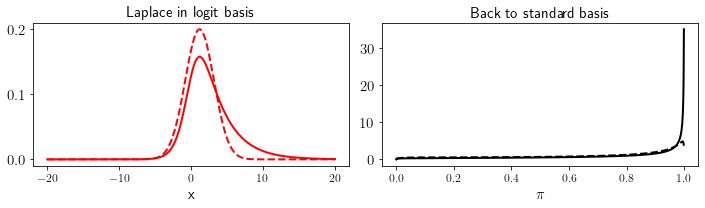

In [193]:
plot_beta_t_logit(alpha_real2_c, 40)

<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in true_divide
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:7: RuntimeWarning: divide by zero encountered in log
  return(np.log(theta/(1-theta)))
<ipython-input-124-ef739ff61aeb>:10: RuntimeWarning: divide by zero encountered in true_divide
  return(1/x + 1/(1-x))
<ipython-input-124-ef739ff61aeb>:46: RuntimeWarning: invalid value encountered in multiply
  return(norm.pdf(x_, mu, sigma) * logit_derivative(x))
<ipython-input-124-ef739ff61aeb>:20: RuntimeWarning: divide by zero encountered in power
  nom = x ** (a-1) * (1 - x) ** (b-1)


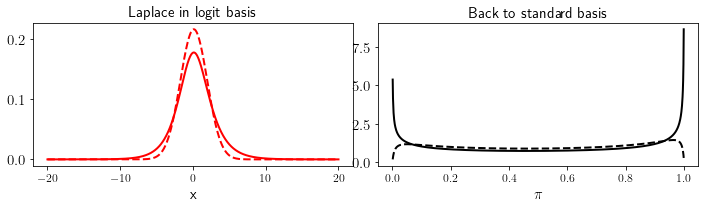

In [195]:
plot_beta_t_logit(alpha_real2_cc, 40)

In [183]:
mu_real3 = np.array([ -8.2520,  -2.1058,  16.4355,  -5.7994,  -4.0799])
Sigma_real3 = np.array([[  6988.7236,      0.0000,      0.0000,      0.0000,      0.0000],
                     [     0.0000,  16933.8125,      0.0000,      0.0000,      0.0000],
                     [     0.0000,      0.0000,   4263.9048,      0.0000,      0.0000],
                     [     0.0000,      0.0000,      0.0000,   4575.6382,      0.0000],
                     [     0.0000,      0.0000,      0.0000,      0.0000,  69514.2812]])

mu_real3_c = correct_mu(mu_real3, Sigma_real3)
Sigma_real3_c = correct_Sigma(mu_real3, Sigma_real3)
mu_real3_c /= np.diag(Sigma_real3_c)
Sigma_real3_c /= Sigma_real3_c

print(mu_real3_c)
print(Sigma_real3_c)

alpha_real3 = get_alpha_from_Normal(mu_real3, Sigma_real3)
alpha_real3_full = get_alpha_from_Normal_full(mu_real3, Sigma_real3)
print("alpha_real3: ", alpha_real3)
print("alpha_real3_full: ", alpha_real3_full)

alpha_real3_c = get_alpha_from_Normal(mu_real3_c, Sigma_real3_c)
alpha_real3_c_full = get_alpha_from_Normal_full(mu_real3_c, Sigma_real3_c)
print("alpha_real3_c: ", alpha_real3_c)
print("alpha_real3_c_full: ", alpha_real3_c_full)

print("mean3: ", alpha_real3 / alpha_real3.sum())
print("mean3_c: ", alpha_real3_c / alpha_real3_c.sum())

[-1.22746415e-03 -1.04484238e-04  4.06104020e-03 -1.28789977e-03
 -6.71861138e-05]
[[1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1.]]
alpha_real3:  [9.21692251e-05 1.25271033e-03 5.45407857e+05 2.43223370e-04
 4.98154445e-05]
alpha_real3_full:  [1.84338450e-05 2.50542066e-04 1.09081571e+05 4.86446740e-05
 9.96308891e-06]
alpha_real3_c:  [0.79970016 0.79992454 0.80075907 0.79968809 0.799932  ]
alpha_real3_c_full:  [ 1.11022302e-17  1.11022302e-17 -1.11022302e-17 -1.66533454e-17
  0.00000000e+00]
mean3:  [1.68991377e-10 2.29683219e-09 9.99999997e-01 4.45947681e-10
 9.13361326e-11]
mean3_c:  [0.19992485 0.19998094 0.20018957 0.19992183 0.19998281]


In [220]:
# first in-dist MNIST sample
mu_real4_c = np.array([-4.8810,  1.9949,  2.7766,  3.6046, -4.9315, -1.5197, -8.8093, 13.4708, -3.3499,  1.6446])
Sigma_real4_c = np.array([
        [ 20.2388,  -1.4815,  -0.7205,  -1.3855,  -3.0852,  -2.2861,  -7.8814, -0.5418,  -1.7603,  -1.0965],
        [ -1.4815,  13.3855,  -0.4572,  -0.8793,  -1.9579,  -1.4508,  -5.0018, -0.3438,  -1.1172,  -0.6958],
        [ -0.7205,  -0.4572,   6.7443,  -0.4276,  -0.9522,  -0.7056,  -2.4324, -0.1672,  -0.5433,  -0.3384],
        [ -1.3855,  -0.8793,  -0.4276,  12.5754,  -1.8311,  -1.3569,  -4.6778, -0.3216,  -1.0448,  -0.6508],
        [ -3.0852,  -1.9579,  -0.9522,  -1.8311,  25.7555,  -3.0214, -10.4161, -0.7160,  -2.3265,  -1.4491],
        [ -2.2861,  -1.4508,  -0.7056,  -1.3569,  -3.0214,  19.8675,  -7.7184, -0.5306,  -1.7239,  -1.0738],
        [ -7.8814,  -5.0018,  -2.4324,  -4.6778, -10.4161,  -7.7184,  49.6024, -1.8292,  -5.9433,  -3.7019],
        [ -0.5418,  -0.3438,  -0.1672,  -0.3216,  -0.7160,  -0.5306,  -1.8292, 5.1133,  -0.4086,  -0.2545],
        [ -1.7603,  -1.1172,  -0.5433,  -1.0448,  -2.3265,  -1.7239,  -5.9433, -0.4086,  15.6947,  -0.8268],
        [ -1.0965,  -0.6958,  -0.3384,  -0.6508,  -1.4491,  -1.0738,  -3.7019, -0.2545,  -0.8268,  10.0875]])

mu_real4_c /= 0.9 * np.sqrt(np.diag(Sigma_real4_c))
Sigma_real4_c /= 0.9 * Sigma_real4_c

alpha_real4_c = get_alpha_from_Normal(mu_real4_c, Sigma_real4_c)
print("alpha_real4_c: ", alpha_real4_c)
print("condition: ", condition(alpha_real4_c))

print("mean4_c: ", alpha_real4_c / alpha_real4_c.sum())
# sm mean: 
#[2.4344677e-06 2.9705160e-03 4.6617063e-03 5.6950189e-03 1.3493338e-05
# 1.4253784e-03 9.4698429e-08 9.8440039e-01 1.8027768e-05 8.1300479e-04]

alpha_real4_c:  [  0.76327656   0.98479988   1.19394495   1.16699391   0.76907911
   0.81891889   0.75599374 108.97550235   0.77646353   0.97684469]
condition:  [False False False False False False False  True False False]
mean4_c:  [0.00651361 0.00840403 0.01018882 0.00995883 0.00656313 0.00698845
 0.00645146 0.92996938 0.00662614 0.00833615]


In [189]:
# FMNIST OOD example
mu_real5_c = np.array([ 3.5397e-01,  6.3125e+00,  5.3475e+00, -2.1314e+00, -1.2655e+00,  
                       -5.0167e-03,  4.6985e+00, -3.0206e+00, -3.3208e+00, -6.9691e+00])
Sigma_real5_c = np.array([[ 5.6529, -0.6200, -0.3312, -0.6499, -0.8346, -0.5978, -0.6116, -0.9482, -0.4800, -0.5795],
        [-0.6200,  5.1464, -0.2979, -0.5845, -0.7506, -0.5376, -0.5501, -0.8528, -0.4317, -0.5212],
        [-0.3312, -0.2979,  2.8880, -0.3123, -0.4010, -0.2872, -0.2938, -0.4555, -0.2306, -0.2784],
        [-0.6499, -0.5845, -0.3123,  5.3665, -0.7868, -0.5636, -0.5766, -0.8939, -0.4525, -0.5463],
        [-0.8346, -0.7506, -0.4010, -0.7868,  6.6677, -0.7237, -0.7404, -1.1479, -0.5811, -0.7016],
        [-0.5978, -0.5376, -0.2872, -0.5636, -0.7237,  4.9811, -0.5303, -0.8222, -0.4162, -0.5025],
        [-0.6116, -0.5501, -0.2938, -0.5766, -0.7404, -0.5303,  5.0840, -0.8412, -0.4259, -0.5141],
        [-0.9482, -0.8528, -0.4555, -0.8939, -1.1479, -0.8222, -0.8412,  7.4189, -0.6602, -0.7971],
        [-0.4800, -0.4317, -0.2306, -0.4525, -0.5811, -0.4162, -0.4259, -0.6602,  4.0818, -0.4035],
        [-0.5795, -0.5212, -0.2784, -0.5463, -0.7016, -0.5025, -0.5141, -0.7971, -0.4035,  4.8442]])

mu_real5_c /= np.sqrt(np.diag(Sigma_real5_c))
Sigma_real5_c /= Sigma_real5_c

alpha_real5_c = get_alpha_from_Normal(mu_real5_c, Sigma_real5_c)
print("alpha_real5_c: ", alpha_real5_c)
print("condition: ", condition(alpha_real5_c))

print("mean5_c: ", alpha_real5_c / alpha_real5_c.sum())
#sm mean:
#[1.30892254e-03 5.30074775e-01 3.59952837e-01 1.74922723e-04 2.62023357e-04
# 1.05871470e-03 1.06884345e-01 7.99269619e-05 1.29940396e-04 7.35641661e-05]

alpha_real5_c:  [1.242888   6.9673923  9.67608668 0.95207471 1.03377304 1.18076829
 3.86634279 0.92589641 0.87375585 0.81608745]
condition:  [False False  True False False False False False False False]
mean5_c:  [0.04513837 0.25303707 0.35140961 0.03457681 0.03754387 0.04288235
 0.14041524 0.03362608 0.03173248 0.02963812]


In [17]:
from scipy.stats import multivariate_normal as mvnorm

normal_real1 = mvnorm(mu_real1, Sigma_real1)
samples1 = normal_real1.rvs(1000)
samples1_sm = np.exp(samples1) / np.exp(samples1).sum(1).reshape(-1, 1)
print(samples1_sm.mean(0))
#print(samples_sm)

[0.51253614 0.48746386]


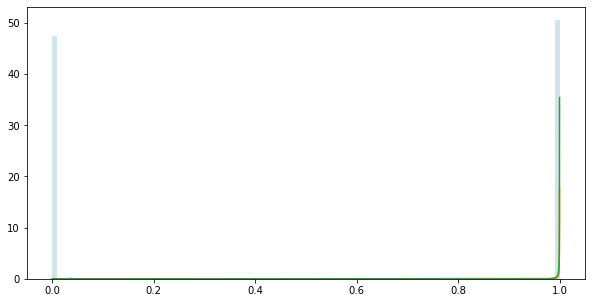

In [37]:
# compare in plots
from scipy.stats import beta
x_ = np.linspace(0, 1, 10000+1)
beta1 = beta.pdf(x_, alpha_real1[0], alpha_real1[1])
beta1_c = beta.pdf(x_, alpha_real1_c[0], alpha_real1_c[1])

plt.figure(figsize=(10, 5))

plt.hist(samples1_sm[:,0], density=True, bins=100, alpha=0.2)
plt.plot(x_, 100*beta1)
plt.plot(x_, 100*beta1_c)
plt.show();

In [38]:
normal_real2 = mvnorm(mu_real2, Sigma_real2)
samples2 = normal_real2.rvs(50)
samples2_sm = np.exp(samples2) / np.exp(samples2).sum(1).reshape(-1, 1)
print(samples2_sm.mean(0))
#print(samples_sm)

[0.68499121 0.31500879]


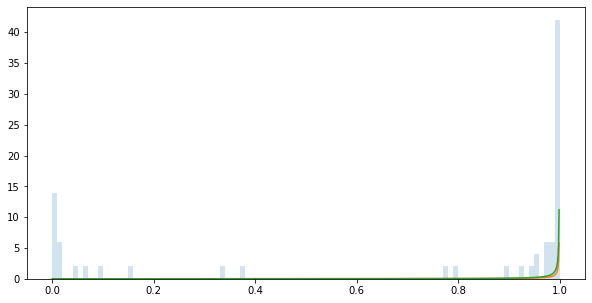

In [39]:
x_ = np.linspace(0, 1, 1000+1)
beta2 = beta.pdf(x_, alpha_real2[0], alpha_real2[1])
beta2_c = beta.pdf(x_, alpha_real2_c[0], alpha_real2_c[1])

plt.figure(figsize=(10, 5))

plt.hist(samples2_sm[:,0], density=True, bins=100, alpha=0.2)
plt.plot(x_, beta2)
plt.plot(x_, beta2_c)
plt.show();

# Analysis: why does it translate badly and when?

ratios:  [1.41421356 1.41421356]
mu c:  [0. 0.]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [0. 0.]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [1. 1.]
alpha_cc:  [0.5 0.5]


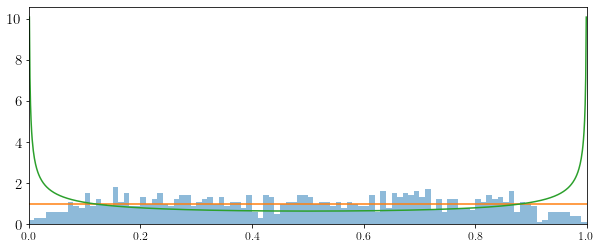

ratios:  [1.72732435 1.15786013]
mu c:  [ 0.2 -0.2]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 0.28284271 -0.28284271]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [1.24591235 0.83516002]
alpha_cc:  [0.69016354 0.39199268]


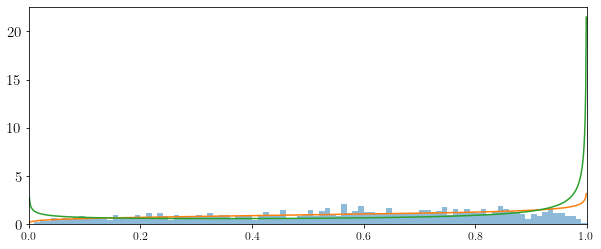

ratios:  [2.10975872 0.9479757 ]
mu c:  [ 0.4 -0.4]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 0.56568542 -0.56568542]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [1.61277046 0.72466448]
alpha_cc:  [1.02497577 0.33064768]


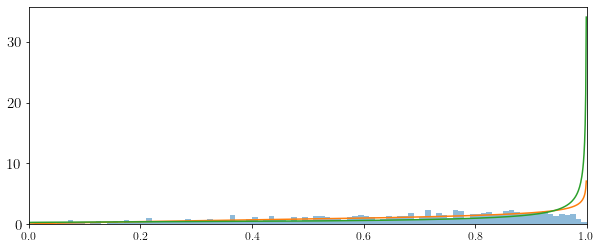

ratios:  [2.57686512 0.77613686]
mu c:  [ 0.6 -0.6]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 0.84852814 -0.84852814]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [2.16005846 0.65059711]
alpha_cc:  [1.61446432 0.29580552]


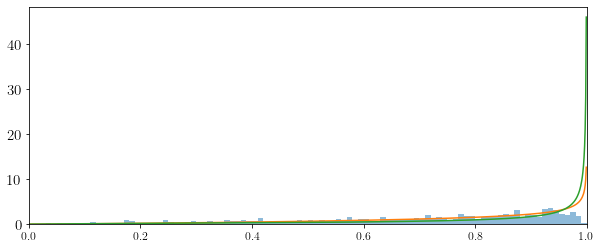

ratios:  [3.14739016 0.63544712]
mu c:  [ 0.8 -0.8]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 1.13137085 -1.13137085]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [2.97651621 0.60094826]
alpha_cc:  [2.65234979 0.27601619]


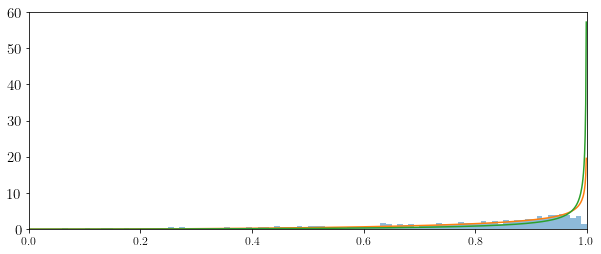

ratios:  [3.84423103 0.5202601 ]
mu c:  [ 1. -1.]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 1.41421356 -1.41421356]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [4.19452805 0.56766764]
alpha_cc:  [4.47970717 0.26477644]


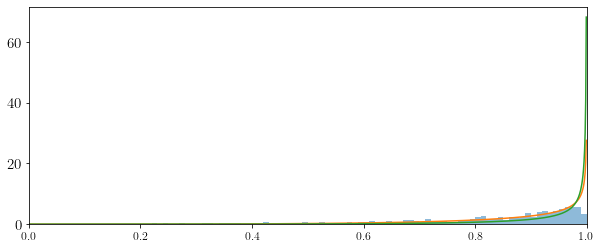

ratios:  [4.69535438 0.42595294]
mu c:  [ 1.2 -1.2]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 1.69705627 -1.69705627]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [6.01158819 0.54535898]
alpha_cc:  [7.69705155 0.25839258]


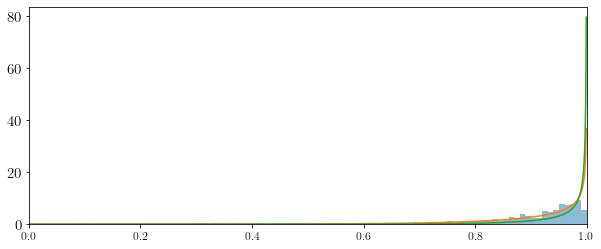

ratios:  [5.73491879 0.34874077]
mu c:  [ 1.4 -1.4]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 1.97989899 -1.97989899]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [8.72232339 0.53040503]
alpha_cc:  [13.36168233  0.25476674]


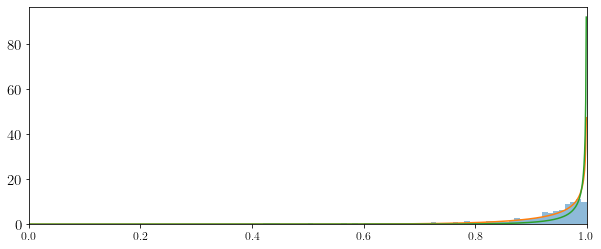

ratios:  [7.00464563 0.28552479]
mu c:  [ 1.6 -1.6]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 2.2627417 -2.2627417]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [12.7662651  0.5203811]
alpha_cc:  [23.33513811  0.25270737]


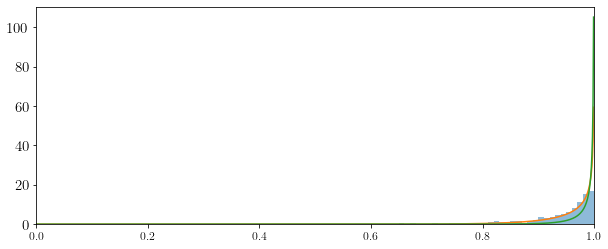

ratios:  [8.55549349 0.23376793]
mu c:  [ 1.8 -1.8]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 2.54558441 -2.54558441]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [18.79911722  0.51366186]
alpha_cc:  [40.89494457  0.25153771]


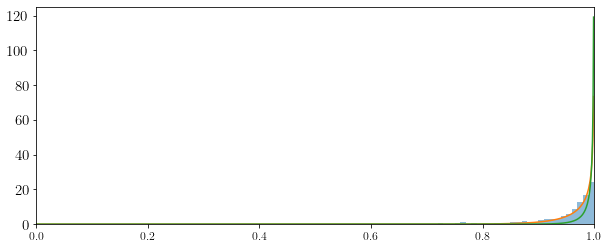

ratios:  [10.44970335  0.19139299]
mu c:  [ 2. -2.]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 2.82842712 -2.82842712]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [27.79907502  0.50915782]
alpha_cc:  [71.81169096  0.25087337]


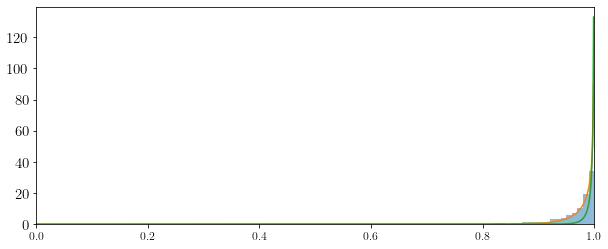

ratios:  [12.76329649  0.15669933]
mu c:  [ 2.2 -2.2]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 3.11126984 -3.11126984]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [41.22543433  0.50613867]
alpha_cc:  [126.24538929   0.25049605]


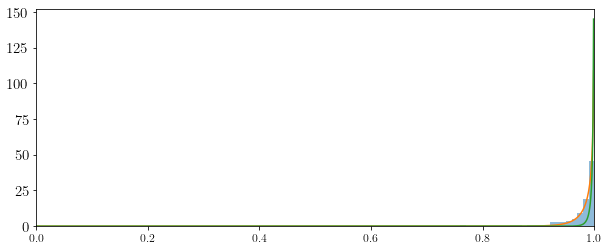

ratios:  [15.58912554  0.12829456]
mu c:  [ 2.4 -2.4]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 3.39411255 -3.39411255]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [61.25520876  0.50411487]
alpha_cc:  [222.08430699   0.25028174]


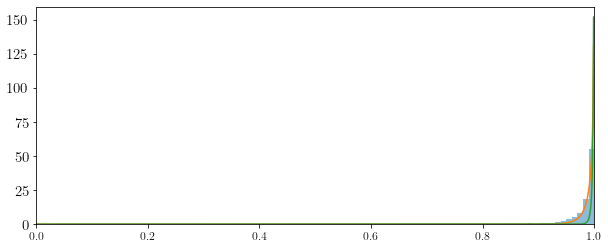

ratios:  [19.04060093  0.1050387 ]
mu c:  [ 2.6 -2.6]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 3.67695526 -3.67695526]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [91.13612094  0.50275828]
alpha_cc:  [3.90823497e+02 2.50160021e-01]


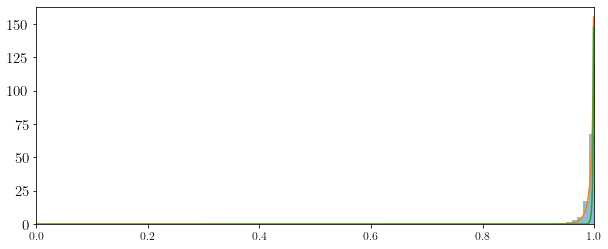

ratios:  [23.25624249  0.08599842]
mu c:  [ 2.8 -2.8]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 3.95979797 -3.95979797]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [135.71320371   0.50184893]
alpha_cc:  [6.87914854e+02 2.50090887e-01]


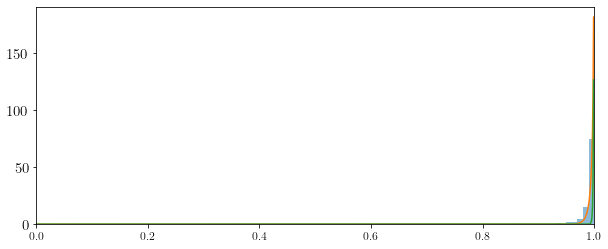

ratios:  [28.40523872  0.07040955]
mu c:  [ 3. -3.]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 4.24264069 -4.24264069]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [202.21439675   0.50123938]
alpha_cc:  [1.21098999e+03 2.50051621e-01]


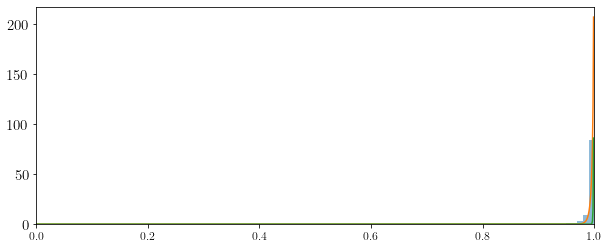

ratios:  [34.69423692  0.05764646]
mu c:  [ 3.2 -3.2]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 4.5254834 -4.5254834]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [301.42251894   0.50083078]
alpha_cc:  [2.13194441e+03 2.50029319e-01]


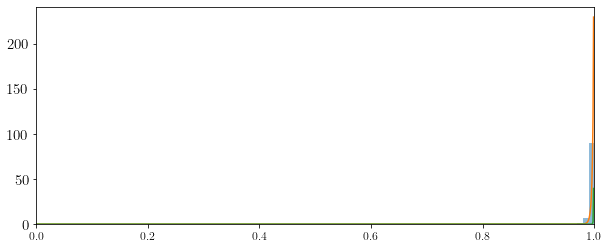

ratios:  [42.37563667  0.04719693]
mu c:  [ 3.4 -3.4]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 4.80832611 -4.80832611]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [449.42364583   0.50055689]
alpha_cc:  [3.75342663e+03 2.50016653e-01]


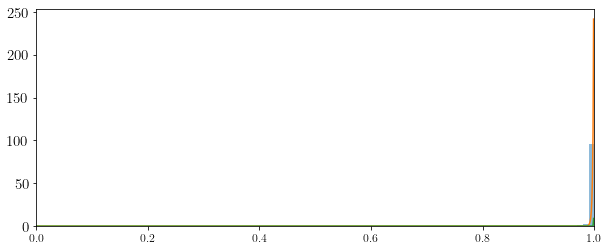

ratios:  [5.17577195e+01 3.86415789e-02]
mu c:  [ 3.6 -3.6]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 5.09116882 -5.09116882]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [6.70215382e+02 5.00373293e-01]
alpha_cc:  [6.60829608e+03 2.50009458e-01]


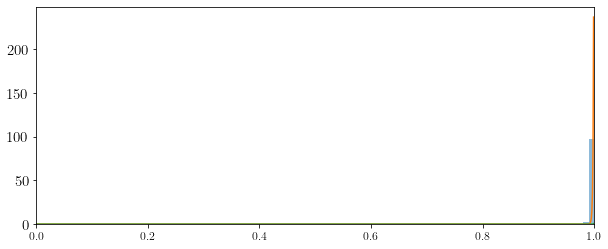

ratios:  [6.32170214e+01 3.16370490e-02]
mu c:  [ 3.8 -3.8]
Sigma c:  [[ 0.5 -0.5]
 [-0.5  0.5]]
mu cc:  [ 5.37401154 -5.37401154]
Sigma cc:  [[1. 1.]
 [1. 1.]]
alpha:  [9.99597948e+02 5.00250226e-01]
alpha_cc:  [1.16347339e+04 2.50005372e-01]


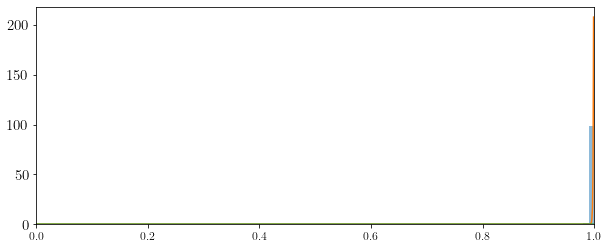

In [216]:
# keep cov constant and change mean
cov = 1*np.eye(2)
x_ = np.linspace(0, 1, 1000+1)

for i in range(20):
    
    mu = np.array([i/5,-i/5])
    mu_c = correct_mu(mu, cov)
    cov_c = correct_Sigma(mu, cov)
    ratios = np.exp(mu_c) / np.sqrt(np.diag(cov_c))
    print("ratios: ", ratios)
    if max(ratios) > 5:
        mu_cc = mu_c / np.sqrt(np.diag(cov_c))
        cov_cc = cov_c / cov_c
    
    print("mu c: ", mu_c)
    print("Sigma c: ", cov_c)
    print("mu cc: ", mu_cc)
    print("Sigma cc: ", cov_cc)
    samples = mvnorm(mu_c, cov).rvs(1000)
    samples_sm = np.exp(samples) / np.exp(samples).sum(1).reshape(-1, 1)
    
    alpha_c = get_alpha_from_Normal(mu_c, cov_c)
    alpha_cc = get_alpha_from_Normal(mu_cc, cov_cc)
    print("alpha: ", alpha_c)
    print("alpha_cc: ", alpha_cc)
    beta_c = beta.pdf(x_, alpha_c[0], alpha_c[1])
    beta_cc = beta.pdf(x_, alpha_cc[0], alpha_cc[1])
    
    plt.figure(figsize=(10, 4))

    plt.hist(samples_sm[:,0], density=True, bins=100, range=[0,1], alpha=0.5)
    plt.xlim(0,1)
    plt.plot(x_, beta_c)
    plt.plot(x_, beta_cc)
    plt.show();
    
## looks fine

mu:  [ 1. -1.]
Sigma:  [[ 5. -5.]
 [-5.  5.]]
alpha:  [0.4194528  0.05676676]
condition:  [False False]


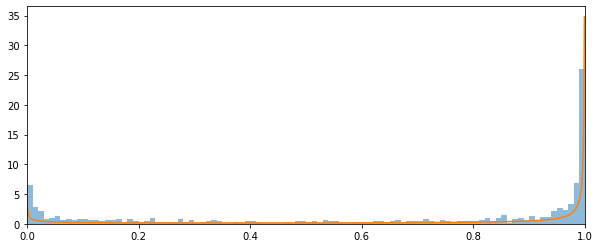

mu:  [ 0.5 -0.5]
Sigma:  [[ 10. -10.]
 [-10.  10.]]
alpha:  [0.09295705 0.03419699]
condition:  [False False]


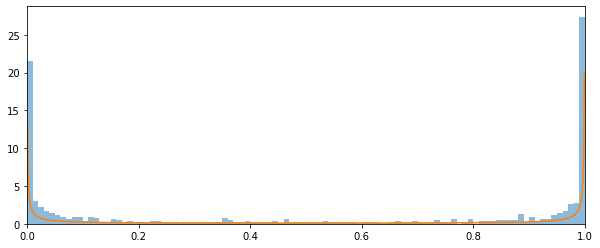

mu:  [ 0.33333333 -0.33333333]
Sigma:  [[ 15. -15.]
 [-15.  15.]]
alpha:  [0.0491289  0.02522362]
condition:  [False False]


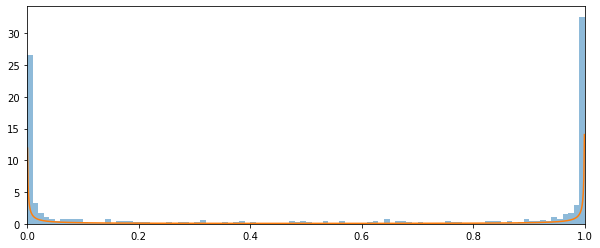

mu:  [ 0.25 -0.25]
Sigma:  [[ 20. -20.]
 [-20.  20.]]
alpha:  [0.03310902 0.02008163]
condition:  [False False]


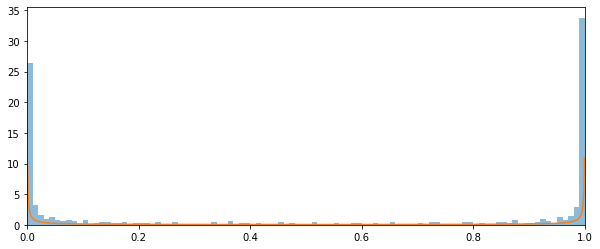

mu:  [ 0.2 -0.2]
Sigma:  [[ 25. -25.]
 [-25.  25.]]
alpha:  [0.02491825 0.0167032 ]
condition:  [False False]


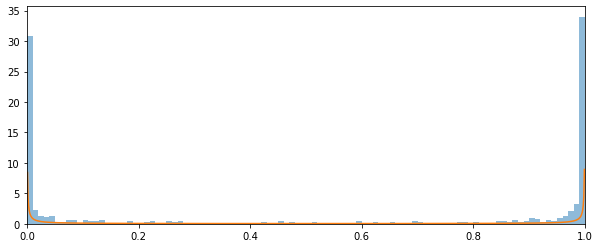

mu:  [ 0.16666667 -0.16666667]
Sigma:  [[ 30. -30.]
 [-30.  30.]]
alpha:  [0.01996344 0.01430443]
condition:  [False False]


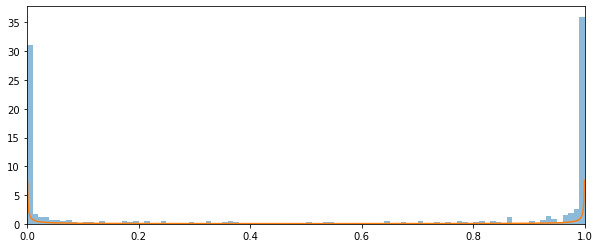

mu:  [ 0.14285714 -0.14285714]
Sigma:  [[ 35. -35.]
 [-35.  35.]]
alpha:  [0.01664794 0.01251055]
condition:  [False False]


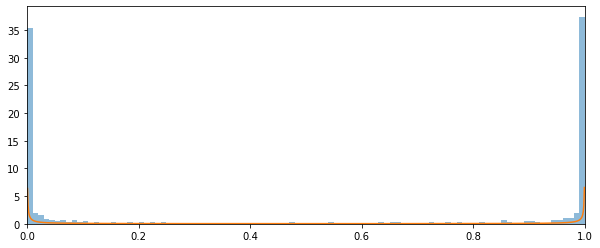

mu:  [ 0.125 -0.125]
Sigma:  [[ 40. -40.]
 [-40.  40.]]
alpha:  [0.01427516 0.0111175 ]
condition:  [False False]


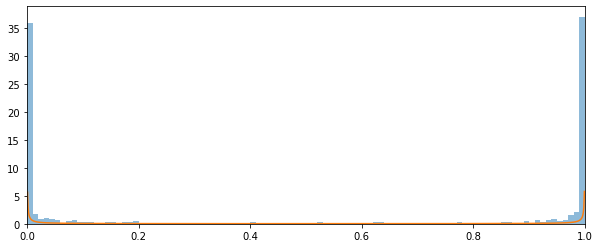

mu:  [ 0.11111111 -0.11111111]
Sigma:  [[ 45. -45.]
 [-45.  45.]]
alpha:  [0.0124936 0.0100041]
condition:  [False False]


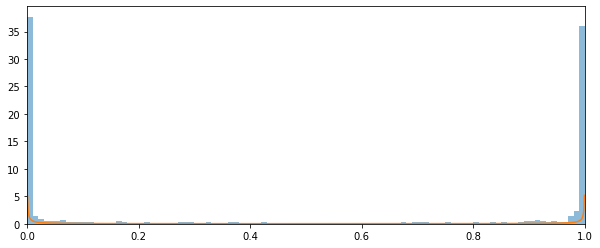

mu:  [ 0.1 -0.1]
Sigma:  [[ 50. -50.]
 [-50.  50.]]
alpha:  [0.01110701 0.00909365]
condition:  [False False]


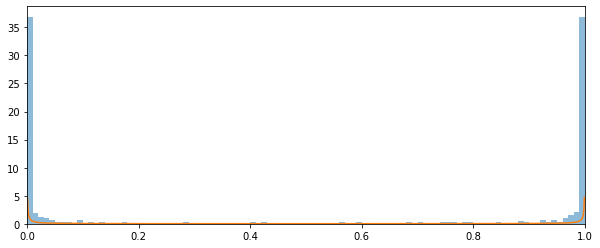

mu:  [ 0.09090909 -0.09090909]
Sigma:  [[ 55. -55.]
 [-55.  55.]]
alpha:  [0.00999726 0.00833524]
condition:  [False False]


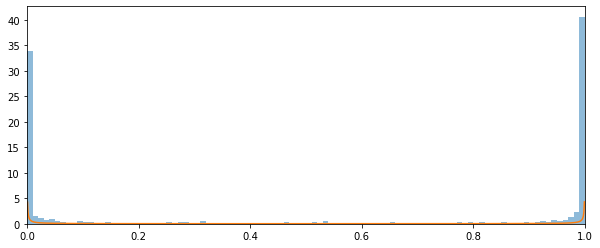

mu:  [ 0.08333333 -0.08333333]
Sigma:  [[ 60. -60.]
 [-60.  60.]]
alpha:  [0.009089   0.00769367]
condition:  [False False]


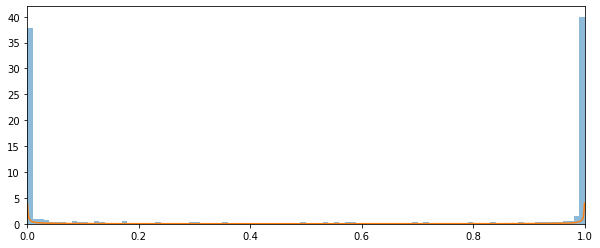

mu:  [ 0.07692308 -0.07692308]
Sigma:  [[ 65. -65.]
 [-65.  65.]]
alpha:  [0.00833197 0.00714386]
condition:  [False False]


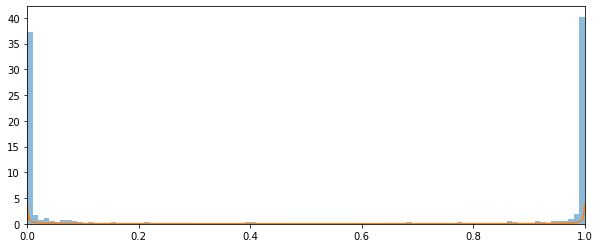

mu:  [ 0.07142857 -0.07142857]
Sigma:  [[ 70. -70.]
 [-70.  70.]]
alpha:  [0.0076913  0.00666742]
condition:  [False False]


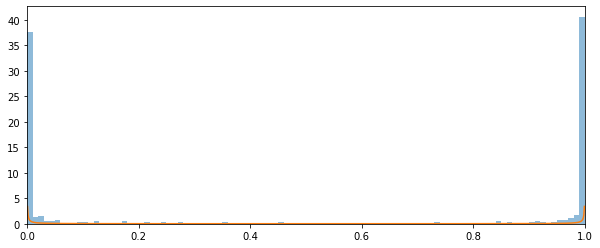

mu:  [ 0.06666667 -0.06666667]
Sigma:  [[ 75. -75.]
 [-75.  75.]]
alpha:  [0.0071421  0.00625058]
condition:  [False False]


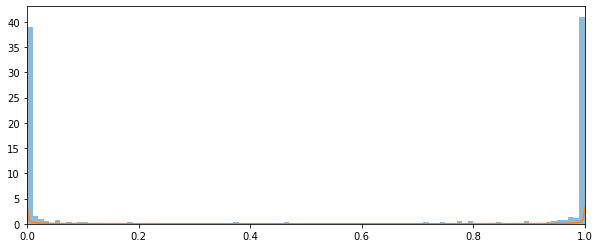

mu:  [ 0.0625 -0.0625]
Sigma:  [[ 80. -80.]
 [-80.  80.]]
alpha:  [0.00666609 0.0058828 ]
condition:  [False False]


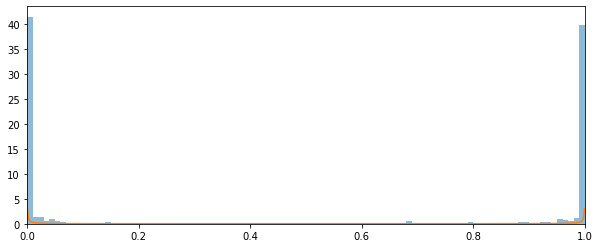

mu:  [ 0.05882353 -0.05882353]
Sigma:  [[ 85. -85.]
 [-85.  85.]]
alpha:  [0.00624955 0.00555591]
condition:  [False False]


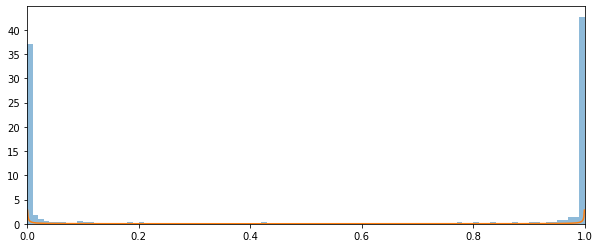

mu:  [ 0.05555556 -0.05555556]
Sigma:  [[ 90. -90.]
 [-90.  90.]]
alpha:  [0.005882   0.00526344]
condition:  [False False]


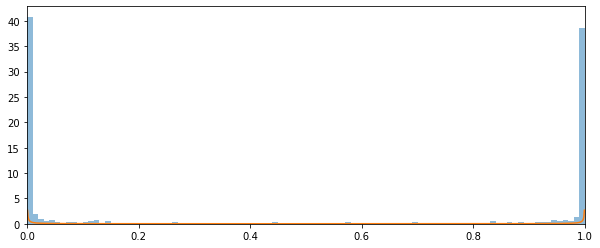

mu:  [ 0.05263158 -0.05263158]
Sigma:  [[ 95. -95.]
 [-95.  95.]]
alpha:  [0.00555527 0.00500023]
condition:  [False False]


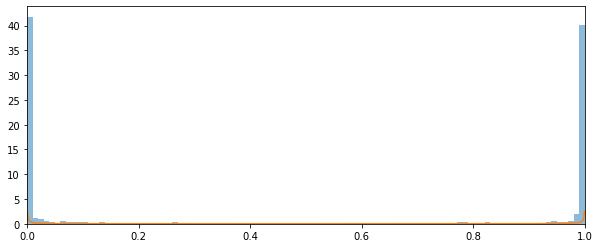

mu:  [ 0.05 -0.05]
Sigma:  [[ 100. -100.]
 [-100.  100.]]
alpha:  [0.00526293 0.00476209]
condition:  [False False]


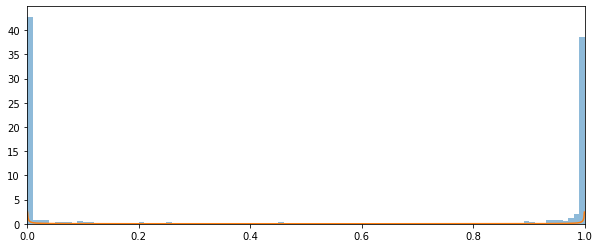

In [58]:
# keep mean constant and change cov
base_cov = np.eye(2)
x_ = np.linspace(0, 1, 1000+1)
#mu = np.array([0,0])
mu = np.array([5, -5])

for i in range(20):
    
    cov = (i+1) * 10 * base_cov
    mu_c = correct_mu(mu, cov)
    cov_c = correct_Sigma(mu, cov)
    #mu_c /= cov_c.max()
    print("mu: ", mu_c)
    print("Sigma: ", cov_c)
    samples = mvnorm(mu_c, cov).rvs(1000)
    samples_sm = np.exp(samples) / np.exp(samples).sum(1).reshape(-1, 1)
    
    alpha_c = get_alpha_from_Normal(mu_c, cov_c)
    print("alpha: ", alpha_c)
    print("condition: ", condition(alpha_c))
    beta_c = beta.pdf(x_, alpha_c[0], alpha_c[1])
    
    plt.figure(figsize=(10, 4))

    plt.hist(samples_sm[:,0], density=True, bins=100, range=[0,1], alpha=0.5)
    plt.xlim(0,1)
    plt.plot(x_, beta_c)
    plt.show();
    
## looks kinda good

mu:  [0. 0.]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.5 0.5]
condition:  [False False]


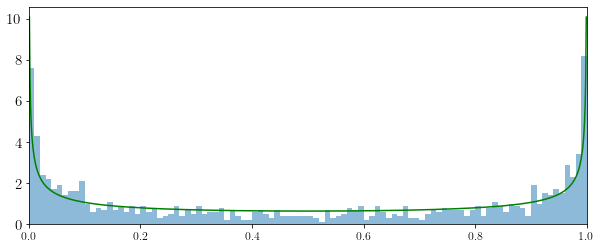

mu:  [ 0.08944272 -0.08944272]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.54897093 0.45905042]
condition:  [False False]


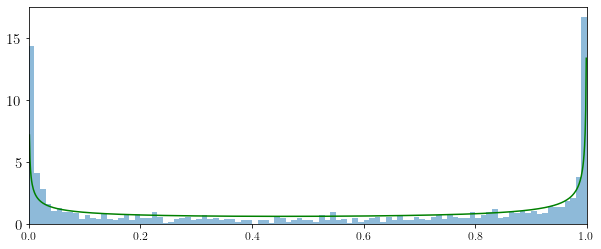

mu:  [ 0.14605935 -0.14605935]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.58481549 0.43666998]
condition:  [False False]


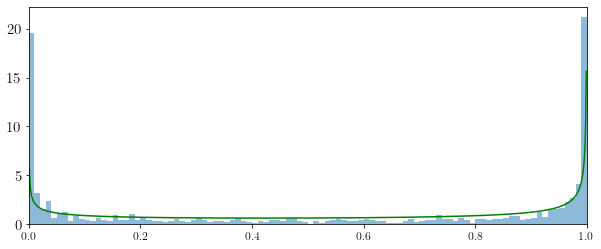

mu:  [ 0.18973666 -0.18973666]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.61537866 0.42105542]
condition:  [False False]


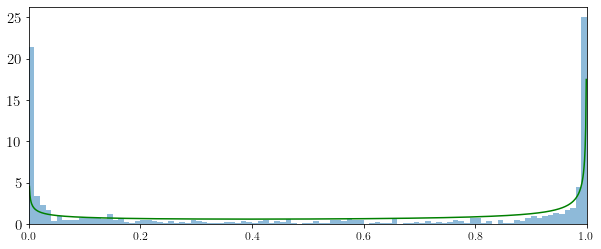

mu:  [ 0.22627417 -0.22627417]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.64307847 0.40900133]
condition:  [False False]


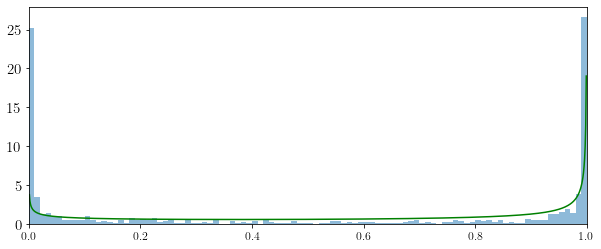

mu:  [ 0.25819889 -0.25819889]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.66899488 0.3991665 ]
condition:  [False False]


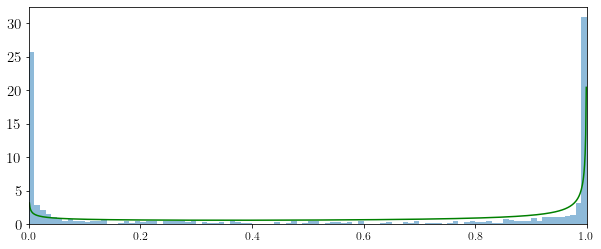

mu:  [ 0.28685487 -0.28685487]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.69370976 0.39085784]
condition:  [False False]


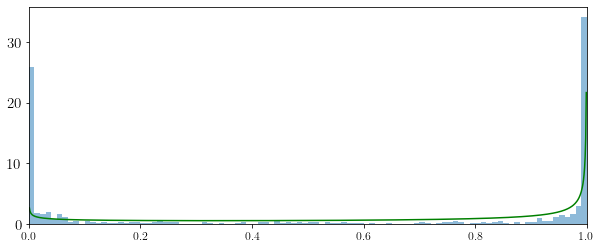

mu:  [ 0.31304952 -0.31304952]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.71757509 0.38366837]
condition:  [False False]


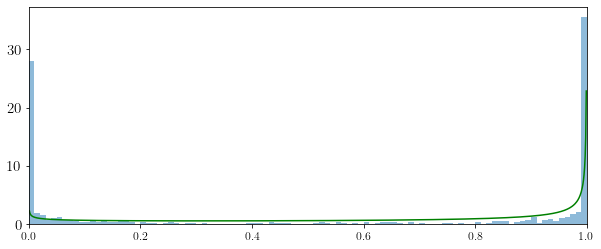

mu:  [ 0.33730962 -0.33730962]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.74082132 0.37733758]
condition:  [False False]


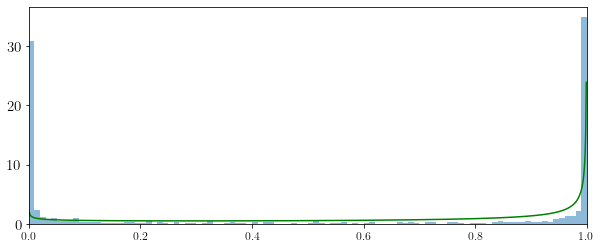

mu:  [ 0.36 -0.36]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.7636083  0.37168806]
condition:  [False False]


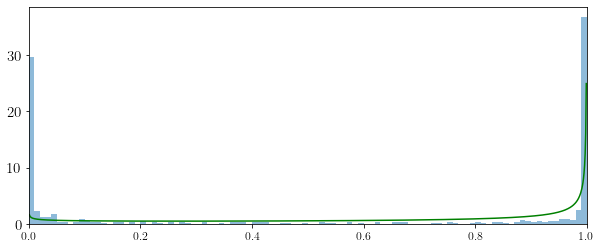

mu:  [ 0.38138504 -0.38138504]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.7860519  0.36659319]
condition:  [ True False]


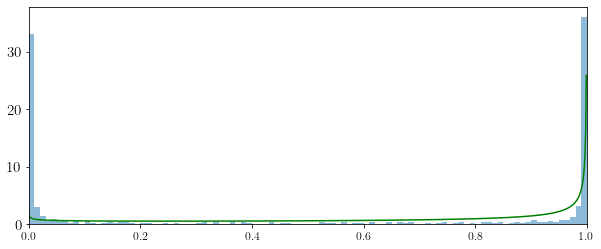

mu:  [ 0.40166321 -0.40166321]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.80823908 0.3619592 ]
condition:  [ True False]


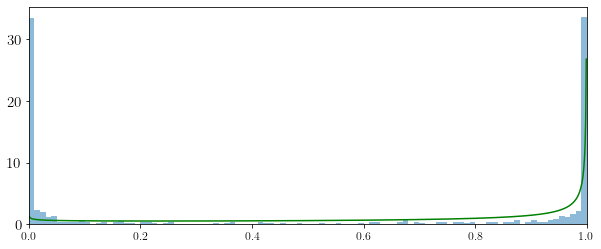

mu:  [ 0.42098785 -0.42098785]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.83023699 0.35771461]
condition:  [ True False]


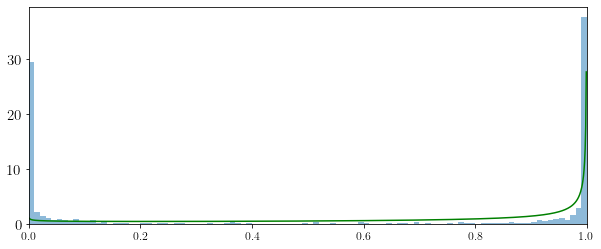

mu:  [ 0.43948021 -0.43948021]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.85209867 0.35380358]
condition:  [ True False]


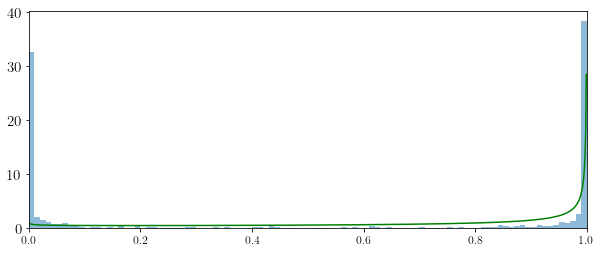

mu:  [ 0.45723809 -0.45723809]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.87386693 0.35018162]
condition:  [ True False]


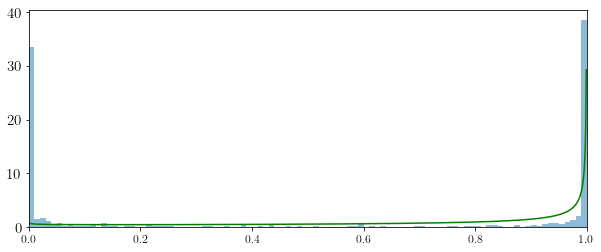

mu:  [ 0.47434165 -0.47434165]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.89557682 0.34681265]
condition:  [ True False]


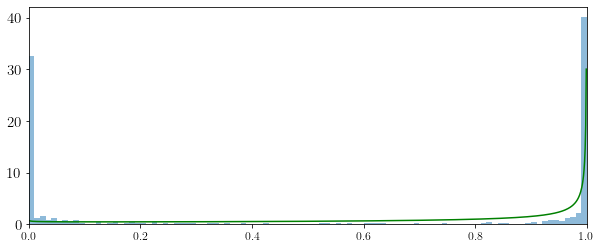

mu:  [ 0.49085759 -0.49085759]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.91725755 0.34366698]
condition:  [ True False]


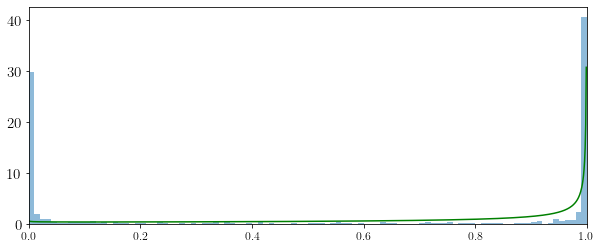

mu:  [ 0.50684207 -0.50684207]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.93893372 0.3407199 ]
condition:  [ True False]


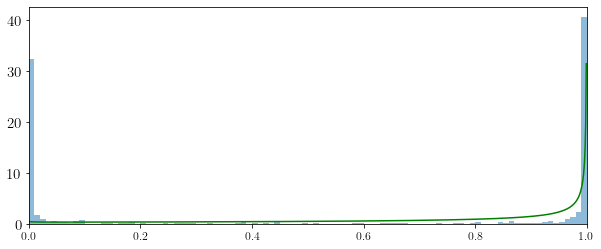

mu:  [ 0.5223429 -0.5223429]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.96062632 0.33795058]
condition:  [ True False]


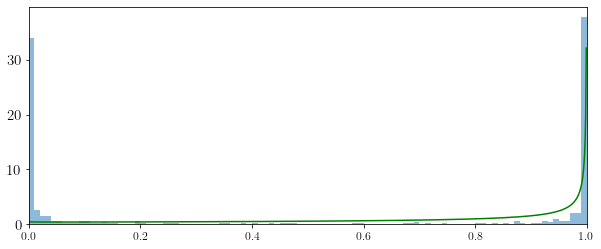

mu:  [ 0.53740115 -0.53740115]
Sigma:  [[1. 1.]
 [1. 1.]]
alpha:  [0.98235343 0.33534131]
condition:  [ True False]


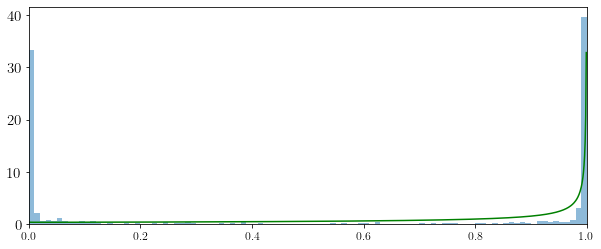

In [200]:
# change mean and cov
base_cov = np.eye(2)
x_ = np.linspace(0, 1, 1000+1)


for i in range(20):
    
    mu = np.array([i/5, -i/5])
    cov = (i+1) * 5 * base_cov
    
    mu_c = correct_mu(mu, cov)
    cov_c = correct_Sigma(mu, cov)
    mu_c /= np.sqrt(np.diag(cov_c))
    cov_c /= cov_c
    print("mu: ", mu_c)
    print("Sigma: ", cov_c)
    samples = mvnorm(mu_c, cov).rvs(1000)
    samples_sm = np.exp(samples) / np.exp(samples).sum(1).reshape(-1, 1)
    
    alpha_c = get_alpha_from_Normal(mu_c, cov_c)
    print("alpha: ", alpha_c)
    print("condition: ", condition(alpha_c))
    beta_c = beta.pdf(x_, alpha_c[0], alpha_c[1])
    #alpha_cc = correct_alpha(alpha_c, kappa=0.9)
    #print("alpha corrected: ", alpha_cc)
    #beta_cc = beta.pdf(x_, alpha_cc[0], alpha_cc[1])
    
    plt.figure(figsize=(10, 4))

    plt.hist(samples_sm[:,0], density=True, bins=100, range=[0,1], alpha=0.5)
    plt.xlim(0,1)
    plt.plot(x_, beta_c, color='green')
    #plt.plot(x_, beta_cc, color='firebrick')
    plt.show();
    

In [ ]:
# in dist sample; we expect alpha_0 << alpha_1 or alpha_1 << alpha_0

mu_real2 = np.array([ -2.4562,   2.4562] )
Sigma_real2 = np.array([[   5.2452,   -5.2452],
                        [  -5.2452,    5.2452]])

mu_real2_c = correct_mu(mu_real2, Sigma_real2)
Sigma_real2_c = correct_Sigma(mu_real2, Sigma_real2)

print(mu_real2_c)
print(Sigma_real2_c)

alpha_real2 = get_alpha_from_Normal(mu_real2, Sigma_real2)
alpha_real2_full = get_alpha_from_Normal_full(mu_real2, Sigma_real2)
print(alpha_real2)
print(alpha_real2_full)

alpha_real2_c = get_alpha_from_Normal(mu_real2_c, Sigma_real2_c)
alpha_real2_c_alt = get_alpha_from_Normal2(mu_real2_c, Sigma_real2_c)
alpha_real2_c_full = get_alpha_from_Normal_full(mu_real2_c, Sigma_real2_c)
print("alpha: ", alpha_real2_c)
print("alpha alt: ", alpha_real2_c_alt)
#print(alpha_real2_c_full)

print("mean2: ", alpha_real2 / alpha_real2.sum())
print("mean2_c: ", alpha_real2_c / alpha_real2_c.sum())

alpha_real2_cc = correct_alpha(alpha_real2_c, kappa=0.9)
print("after alpha2 correction: ", alpha_real2_cc)

# make the plots

## Plot 1: show the plots for 3 matrices

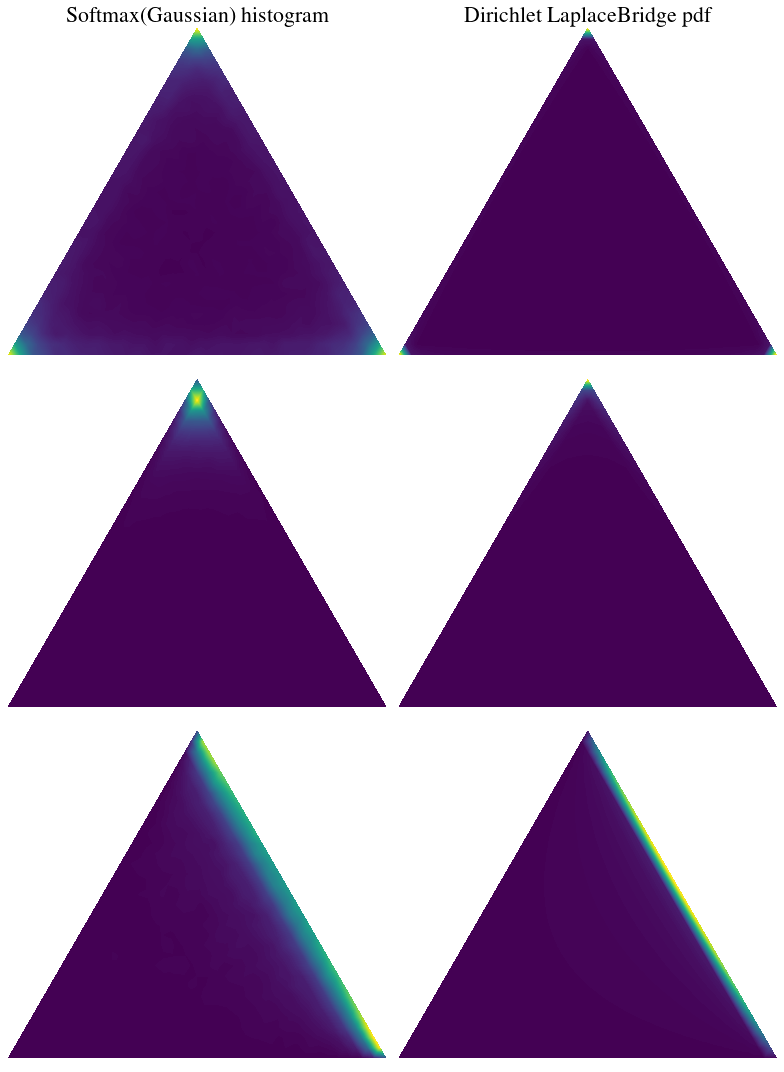

In [25]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=5

MUs_3s = [[0,0,0],
       [-1,-1,2],
       [-2,1,1]]
MUs_3s_vis = np.around(MUs_3s, 2)
SIGMAs_3s = [5*np.eye(3),
          0.1*np.array([[ 9.5938,  1.4385,  2.5147],
         [ 1.4385,  9.5551,  2.5534],
         [ 2.5147,  2.5534,  8.4789]]),
         0.1*np.array([[17.7842,  1.4664,  2.7132],
         [ 1.4664, 17.7394,  2.7580],
         [ 2.7132,  2.7580, 16.4925]])]
SIGMAs_3s_vis = np.around(SIGMAs_3s, 2)

ALPHAs_3s = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_3s, SIGMAs_3s)]
ALPHAs_3s_vis = np.around(ALPHAs_3s, 2)

cols = ['Softmax(Gaussian) histogram', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_3s_vis, SIGMAs_3s_vis, ALPHAs_3s_vis)]

plt.rcParams["font.family"] = "Times New Roman"
fig, axs = plt.subplots(nrows=len(MUs_3s), ncols=2, sharex=False, figsize=(11, 15))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_3s, SIGMAs_3s, ALPHAs_3s)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = axs[idx][0].tricontourf(trimesh, pvals_n, nlevels)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 75
pad_left = -210

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')
   
        
fig.tight_layout()
plt.savefig('figures/comparison3D_3samples.pdf')
#plt.savefig('figures/comparison3D_3samples.png')
plt.show()   
    

[[0.20000000000000004, 0.20000000000000004, 0.20000000000000004], [1.1049088616044094, 1.113393937230126, 12.383568367683885], [0.43535377620870785, 2.6754110534918962, 3.039153407412016]]


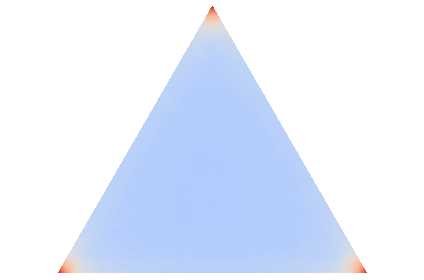

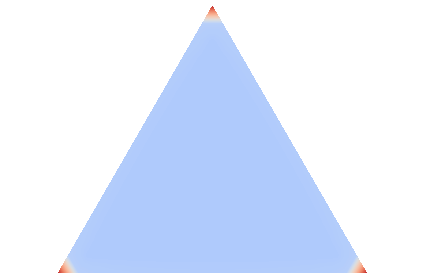

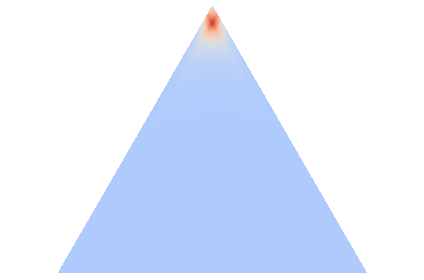

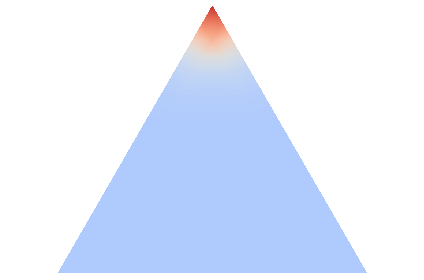

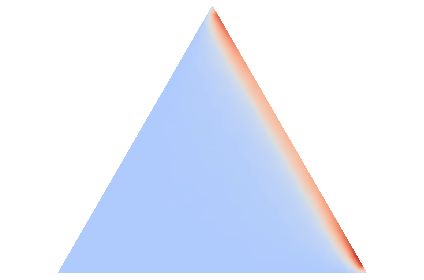

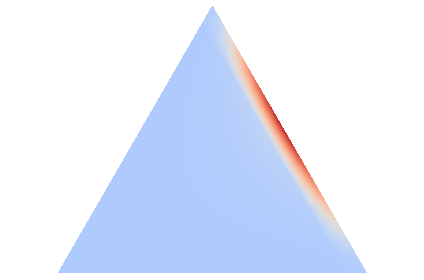

In [60]:
#Tests for the paper

##### save figures individually

num_samples = 100000
nlevels=200
subdiv=5

MUs_3s = [[0,0,0],
       [-1,-1,2],
       [-2,1,1]]
MUs_3s_vis = np.around(MUs_3s, 2)
SIGMAs_3s = [5*np.eye(3),
          0.1*np.array([[ 9.5938,  1.4385,  2.5147],
         [ 1.4385,  9.5551,  2.5534],
         [ 2.5147,  2.5534,  8.4789]]),
         0.1*np.array([[17.7842,  1.4664,  2.7132],
         [ 1.4664, 17.7394,  2.7580],
         [ 2.7132,  2.7580, 16.4925]])]

SIGMAs_3s_corrected = [s - s.mean() for s in SIGMAs_3s]
SIGMAs_3s_vis = np.around(SIGMAs_3s, 2)

ALPHAs_3s = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_3s, SIGMAs_3s_corrected)]
ALPHAs_3s_vis = np.around(ALPHAs_3s, 2)
print(ALPHAs_3s)

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_3s, SIGMAs_3s, ALPHAs_3s)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = plt.tricontourf(trimesh, pvals_n, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.savefig('figures/3samples_Gaussian_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    trimesh = refiner.refine_triangulation(subdiv=4)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = plt.tricontourf(trimesh, pvals_McKay, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.savefig('figures/3samples_Dirichlet_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    #"""
        

    

mus corrected:  [array([0., 0., 0.]), array([-1., -1.,  2.]), array([-2.,  1.,  1.])]
sigmas corrected:  [array([[ 3.33333333, -1.66666667, -1.66666667],
       [-1.66666667,  3.33333333, -1.66666667],
       [-1.66666667, -1.66666667,  3.33333333]]), array([[ 0.50781333, -0.30771667, -0.20009667],
       [-0.30771667,  0.50394333, -0.19622667],
       [-0.20009667, -0.19622667,  0.39632333]]), array([[ 1.04629222, -0.58548778, -0.46080444],
       [-0.58548778,  1.04181222, -0.45632444],
       [-0.46080444, -0.45632444,  0.91712889]])]
alphas:  [array([0.2, 0.2, 0.2]), array([ 1.04728038,  1.0541227 , 12.38435563]), array([0.43953564, 2.19065935, 3.01659686])]


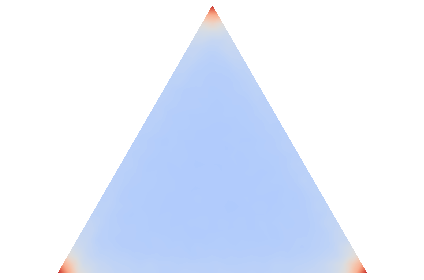

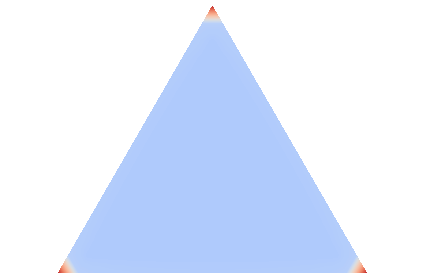

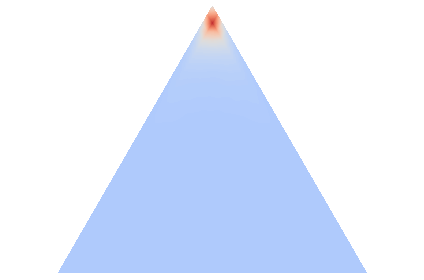

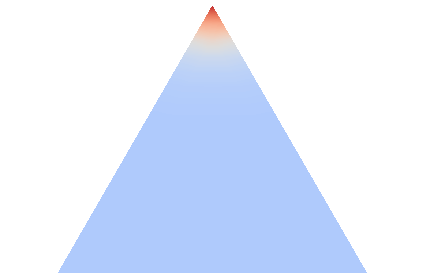

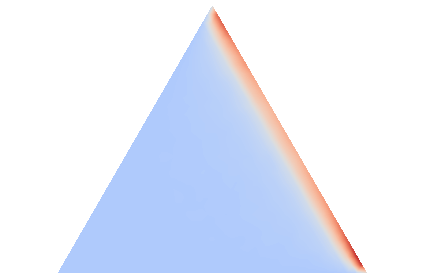

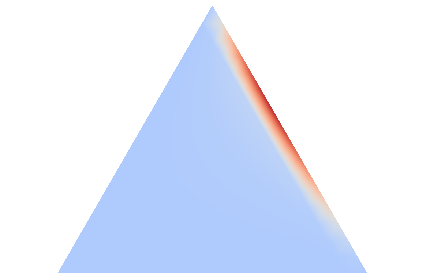

In [19]:
#Tests for the paper

##### save figures individually

num_samples = 100000
nlevels=200
subdiv=5

MUs_3s = np.array([[0,0,0],
       [-1,-1,2],
       [-2,1,1]])
MUs_3s_vis = np.around(MUs_3s, 2)
SIGMAs_3s = [5*np.eye(3),
          0.1*np.array([[ 9.5938,  1.4385,  2.5147],
         [ 1.4385,  9.5551,  2.5534],
         [ 2.5147,  2.5534,  8.4789]]),
         0.1*np.array([[17.7842,  1.4664,  2.7132],
         [ 1.4664, 17.7394,  2.7580],
         [ 2.7132,  2.7580, 16.4925]])]

mus_sigmas = list(zip(MUs_3s, SIGMAs_3s))
# adapt to mean 0 for sigma and mu
MUs_3s = [m - m.mean() for m in MUs_3s]
SIGMAs_3s_corrected = [correct_Sigma(m, s) for m, s in mus_sigmas]
MUs_3s_corrected = [correct_mu(m, s) for m, s in mus_sigmas]
print("mus corrected: ", MUs_3s_corrected)
print("sigmas corrected: ", SIGMAs_3s_corrected)

SIGMAs_3s_vis = np.around(SIGMAs_3s, 2)

ALPHAs_3s = [get_alpha_from_Normal_full(m,s) for m,s in zip(MUs_3s_corrected, SIGMAs_3s_corrected)]
print("alphas: ", ALPHAs_3s)
ALPHAs_3s_vis = np.around(ALPHAs_3s, 2)

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_3s, SIGMAs_3s, ALPHAs_3s)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = plt.tricontourf(trimesh, pvals_n, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.savefig('figures/3samples_Gaussian_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    trimesh = refiner.refine_triangulation(subdiv=4)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = plt.tricontourf(trimesh, pvals_McKay, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    #plt.savefig('figures/3samples_Dirichlet_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    #"""
        

    

In [ ]:
#[[0.20000000000000004, 0.20000000000000004, 0.20000000000000004],
#[1.1049088616044094, 1.1133939372301258, 12.383568367683885], 
#[0.4353547008581983, 2.675416760242385, 3.0391386795715323]]

#full
#[array([0.2, 0.2, 0.2]),
#array([ 1.04728038,  1.0541227 , 12.38435563]),
#array([0.43953564, 2.19065935, 3.01659686])]

## Plot 2: show that increasing uncertainty in the Normal also increases uncertainty in the Dirichlet

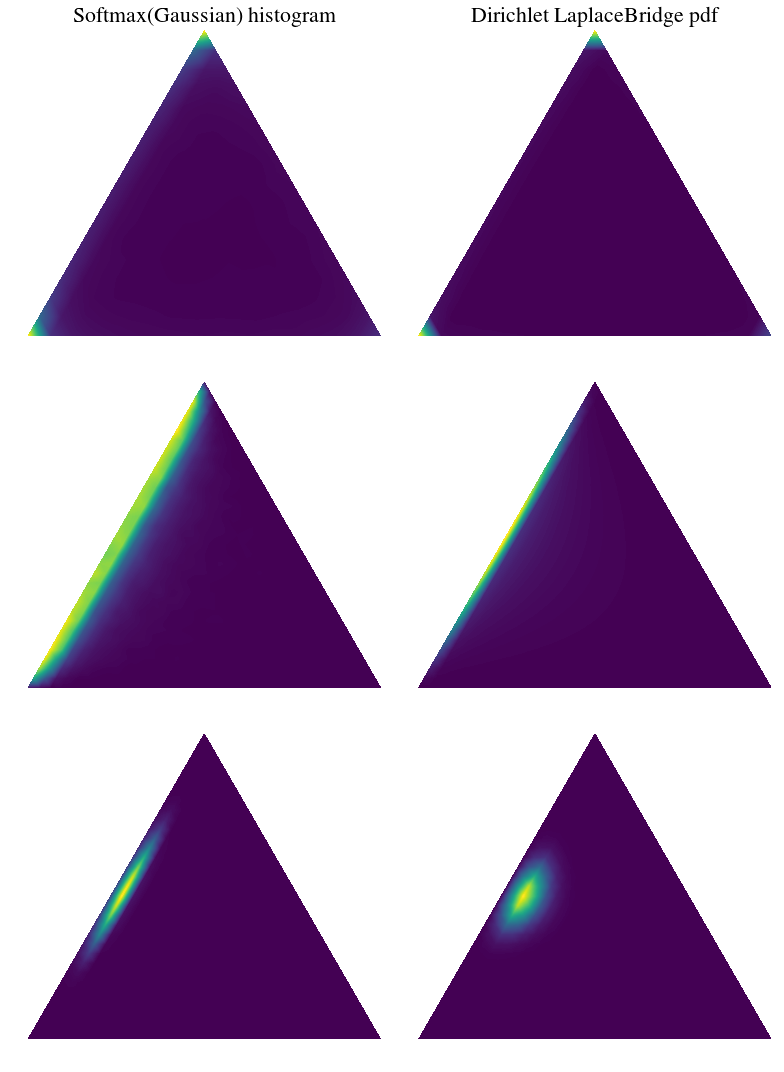

In [24]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=5

MUs_unc = [[1, -2, 1],
           [1, -2, 1],
           [1, -2, 1]]
MUs_unc_vis = np.around(MUs_unc, 2)
SIGMAs_unc = [10*np.eye(3),
              1*np.eye(3), 
              0.1*np.eye(3)]
SIGMAs_unc_vis = np.around(SIGMAs_unc, 2)

ALPHAs_unc = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_unc, SIGMAs_unc)]
ALPHAs_unc_vis = np.around(ALPHAs_unc, 2)

cols = ['Softmax(Gaussian) histogram', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_unc_vis, SIGMAs_unc_vis, ALPHAs_unc_vis)]

plt.rcParams["font.family"] = "Times New Roman"
fig, axs = plt.subplots(nrows=len(MUs_unc), ncols=2, sharex=False, figsize=(11, 15))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_unc, SIGMAs_unc, ALPHAs_unc)):
    
    if idx == 0: subdiv=4
    else: subdiv=5
    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = axs[idx][0].tricontourf(trimesh, pvals_n, nlevels)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 95
pad_left = -230

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')
        
fig.tight_layout()
plt.savefig('figures/comparison3D_Uncertainty.pdf')
#plt.savefig('figures/comparison3D_Uncertainty.png')
plt.show()   
    

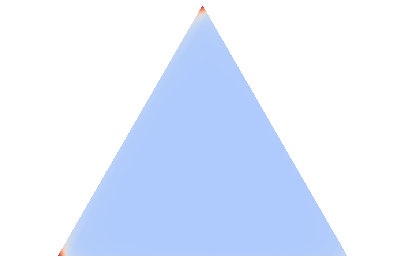

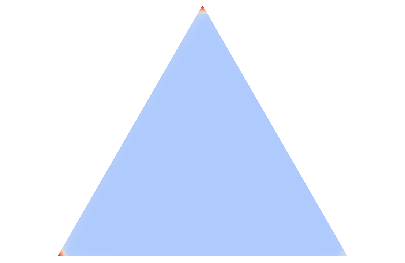

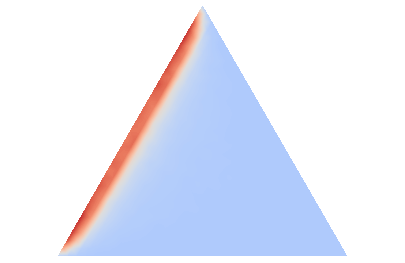

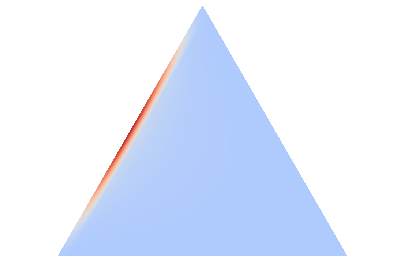

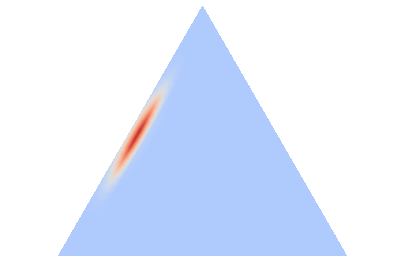

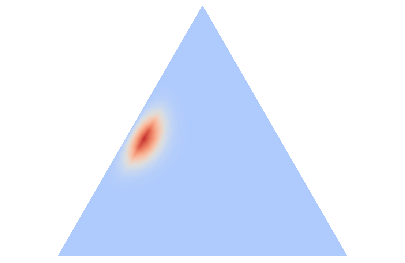

In [18]:
#Tests for the paper

#### individual images

num_samples = 100000
nlevels=200
subdiv=5

MUs_unc = [[1, -2, 1],
           [1, -2, 1],
           [1, -2, 1]]
MUs_unc_vis = np.around(MUs_unc, 2)
SIGMAs_unc = [10*np.eye(3),
              1*np.eye(3), 
              0.1*np.eye(3)]
SIGMAs_unc_vis = np.around(SIGMAs_unc, 2)

ALPHAs_unc = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_unc, SIGMAs_unc)]
ALPHAs_unc_vis = np.around(ALPHAs_unc, 2)

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_unc, SIGMAs_unc, ALPHAs_unc)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = plt.tricontourf(trimesh, pvals_n, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('figures/Uncertainty_Gaussian_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = plt.tricontourf(trimesh, pvals_McKay, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('figures/Uncertainty_Dirichlet_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    #"""

## Plot 3: show that similar MAP is not same distribution

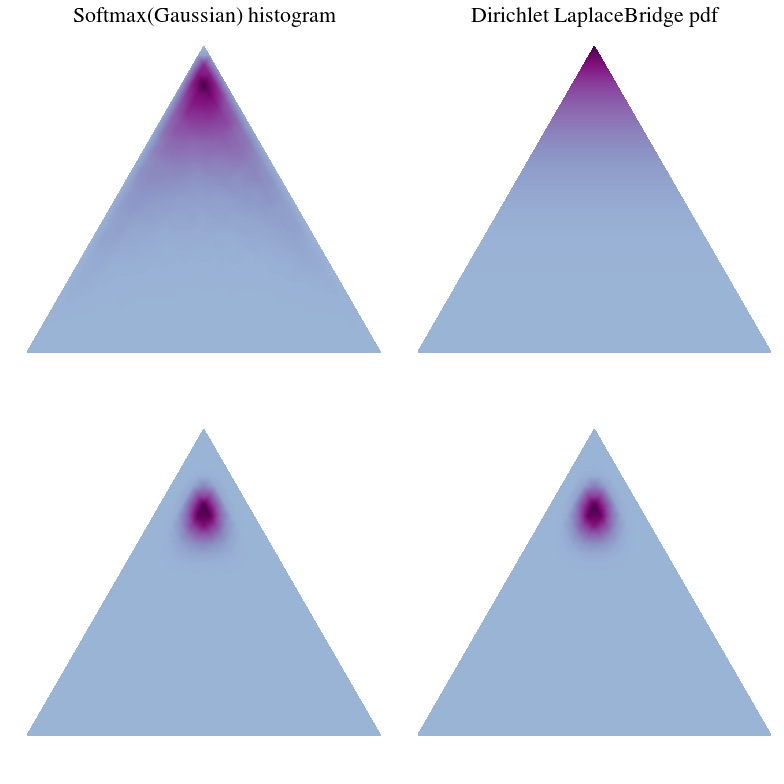

In [16]:
#Tests for the paper

num_samples = 100000
nlevels=200
subdiv=5

MUs_sMAP = [get_mu_from_Dirichlet([1,1,5]),
            get_mu_from_Dirichlet([10,10,50])]
MUs_sMAP_vis = np.around(MUs_sMAP, 2)
SIGMAs_sMAP = [get_Sigma_from_Dirichlet([1,1,5]),
               get_Sigma_from_Dirichlet([10,10,50])]
SIGMAs_sMAP_vis = np.around(SIGMAs_sMAP, 2)

ALPHAs_sMAP = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_sMAP, SIGMAs_sMAP)]
ALPHAs_sMAP_vis = np.around(ALPHAs_sMAP, 2)

cols = ['Softmax(Gaussian) histogram', 'Dirichlet LaplaceBridge pdf']
rows = ['mu: {}; \n Sigma: {}; \n alpha: {}'.format(m, s, a) for m,s,a in zip(MUs_sMAP_vis, SIGMAs_sMAP_vis, ALPHAs_sMAP_vis)]

fig, axs = plt.subplots(nrows=len(MUs_sMAP), ncols=2, sharex=False, figsize=(11, 11))

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_sMAP, SIGMAs_sMAP, ALPHAs_sMAP)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = axs[idx][0].tricontourf(trimesh, pvals_n, nlevels, cmap=new_bupu)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][0].axis('equal')
    axs[idx][0].set_xlim(0, 1)
    axs[idx][0].set_ylim(0, 0.75**0.5)
    axs[idx][0].axis('off')
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = axs[idx][1].tricontourf(trimesh, pvals_McKay, nlevels, cmap=new_bupu)
    for c in cs.collections:
        c.set_rasterized(True)
    axs[idx][1].axis('equal')
    axs[idx][1].set_xlim(0, 1)
    axs[idx][1].set_ylim(0, 0.75**0.5)
    axs[idx][1].axis('off')
    #"""
        

pad_top =  0 # in points

pad_y = 95
pad_left = -230

for ax, col in zip(axs[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad_top),
                xycoords='axes fraction', textcoords='offset points',
                size=22, ha='center', va='baseline')
        
fig.tight_layout()
plt.savefig('figures/comparison3D_sMAP_new_bupu.pdf')
#plt.savefig('figures/comparison3D_sMAP.png')
plt.show()   
    

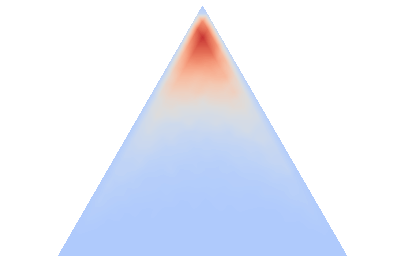

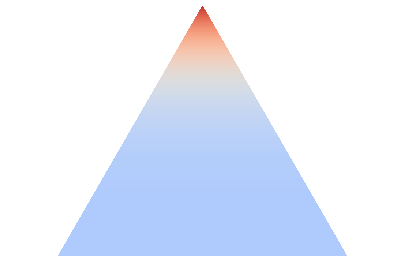

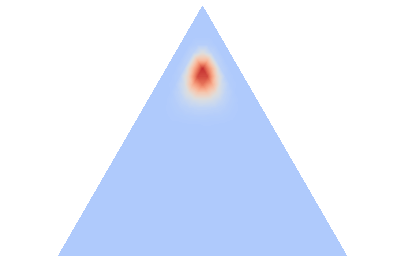

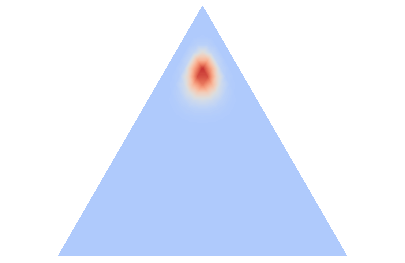

In [19]:
#Tests for the paper

##### single images

num_samples = 100000
nlevels=200
subdiv=5

MUs_sMAP = [get_mu_from_Dirichlet([1,1,5]),
            get_mu_from_Dirichlet([10,10,50])]
MUs_sMAP_vis = np.around(MUs_sMAP, 2)
SIGMAs_sMAP = [get_Sigma_from_Dirichlet([1,1,5]),
               get_Sigma_from_Dirichlet([10,10,50])]
SIGMAs_sMAP_vis = np.around(SIGMAs_sMAP, 2)

ALPHAs_sMAP = [get_alpha_from_Normal(m,s) for m,s in zip(MUs_sMAP, SIGMAs_sMAP)]
ALPHAs_sMAP_vis = np.around(ALPHAs_sMAP, 2)

matplotlib.rcParams['font.family'] = "serif"
matplotlib.rcParams['font.serif'] = 'Times'
matplotlib.rcParams['text.usetex'] = True

for idx, (mu, Sigma, alpha) in enumerate(zip(MUs_sMAP, SIGMAs_sMAP, ALPHAs_sMAP)):
    

    #VALUES
    #softmax(samples)
    gaussian_samples = multivariate_normal.rvs(mean=mu, cov=Sigma, size=num_samples)
    softmax_gaussian_samples = np.array([softmax_transform(x) for x in gaussian_samples])
    #dirichlet_samples
    dirichlet_samples = dirichlet.rvs(alpha, size=num_samples)

    #PLOTS
    refiner = tri.UniformTriRefiner(triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    xys = np.array([xy2bc(xy) for xy in zip(trimesh.x, trimesh.y)])
    #plot softmax(Gaussian) samples
    counts_n = np.zeros(len(xys))
    for x in softmax_gaussian_samples:
        counts_n[argmin_norm(x, xys)] += 1

    pvals_n = counts_n/num_samples

    cs = plt.tricontourf(trimesh, pvals_n, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('figures/sMAP_Gaussian_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    
    #"""
    #plot Dirichlet McKay pdf
    dist_McKay = Dirichlet(alpha)
    pvals_McKay = [dist_McKay.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    cs = plt.tricontourf(trimesh, pvals_McKay, nlevels, cmap=new_coolwarm)
    for c in cs.collections:
        c.set_rasterized(True)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')
    plt.tight_layout()
    plt.margins(0,0)
    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.savefig('figures/sMAP_Dirichlet_coolwarm_{}.png'.format(idx), bbox_inches = 'tight', pad_inches = 0)
    plt.show()
    #"""
    